# Import Necessary Libraries

In [ ]:
from sklearn.linear_model import LinearRegression
import os
import sys
import pandas as pd
import numpy as np
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import shuffle
import scipy.stats as stats
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
import zipfile
import io
from io import StringIO
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import warnings

# **Introduction and Motivation**
### Upon running cross-validation of AdaBoost on 'adult' census data sorced from UCI's Machine Learning data repository, we discovered an anticorrelation phenomena in the training and test error rates.

### We continued to explore this phenomena by running Adaboost CV trials on other sets from UCI's website. Detailed below; what we saw was a pattern detailed in our paper's model. CV run on larger samples and data that was too easy or difficult would lose this anti-correlation effect.

### We also tried to run the experiment on synthetic data to see if this correlation would still exist and if it would confirm our results.

### To keep things consistent we always use 50 estimators in our Adaboost model. We also fix the partition of Holdout/Test/Train to be 10% of data first taken as a Holdout set, then 25% of the remaining portion is the Test set and the rest is the Training set.


# UCI Adult Data Set

#### The Adult data set takes attributes from the census data and aims to classify people as making less than \$50k/yr or more than $50k/yr. We download the set directly from UCI to keep everything contained in this notebook, then preprocess the data to run SkLearn's Adaboost function on the data and run 100 trials of cross validation. This procedure is replicated for all data sets run.

## Relevant Feature Info

#### - Binary Classification
#### - Large data size >48k instances
#### - 14 features

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

# Download and load the UCI Adult dataset
def load_adult_data():
    """
    Download and prepare the UCI Adult dataset
    """
    # URLs for the Adult dataset
    train_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
    test_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

    # Column names for the dataset
    column_names = [
        'age', 'workclass', 'fnlwgt', 'education', 'education-num',
        'marital-status', 'occupation', 'relationship', 'race', 'sex',
        'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
    ]

    # Load the data
    train_data = pd.read_csv(train_url, names=column_names, sep=', ', engine='python')
    test_data = pd.read_csv(test_url, names=column_names, sep=', ', engine='python', skiprows=1)

    # Fix the income column in test set (remove the trailing dot)
    test_data['income'] = test_data['income'].str.rstrip('.')

    # Combine the datasets
    all_data = pd.concat([train_data, test_data])

    # Map the target variable to binary
    all_data['income'] = all_data['income'].map({'<=50K': 0, '>50K': 1, '<=50K.': 0, '>50K.': 1})

    return all_data

# Function to preprocess the Adult dataset
def preprocess_adult_data(data):
    """
    Preprocess the Adult dataset for machine learning
    """
    # Drop rows with missing values for simplicity
    data = data.replace('?', np.nan).dropna()

    # Split features and target
    X = data.drop('income', axis=1)
    y = data['income']

    # Identify numeric and categorical columns
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    # Define preprocessing for numerical and categorical features
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    # Create preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    return X, y, preprocessor

# Define all algorithms to test
def get_algorithms():
    """
    Define the algorithms to compare
    """
    base_learner = DecisionTreeClassifier(max_depth=1)

    algorithms = {
        'AdaBoost': AdaBoostClassifier(
            estimator=base_learner,
            n_estimators=50,
            random_state=42
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42
        ),
        'SVM': SVC(
            kernel='rbf',
            C=1.0,
            random_state=42
        ),
        'Logistic Regression': LogisticRegression(
            max_iter=1000,
            random_state=42
        ),
        'Neural Network': MLPClassifier(
            hidden_layer_sizes=(100, 50),
            max_iter=300,
            random_state=42,
            early_stopping=True,
            validation_fraction=0.1
        )
    }

    return algorithms

# Run cross-validation experiment for all algorithms
def run_multi_algorithm_experiment(X, y, preprocessor, n_runs=100):
    """
    Run the experiment with multiple algorithms using the same CV setup
    """
    algorithms = get_algorithms()
    results = []

    for seed in range(n_runs):
        # Split into train-val and holdout sets
        X_train_val, X_holdout, y_train_val, y_holdout = train_test_split(
            X, y, test_size=0.1, random_state=seed, stratify=y)

        # Further split train-val into train and test
        X_train, X_test, y_train, y_test = train_test_split(
            X_train_val, y_train_val, test_size=0.25, random_state=seed, stratify=y_train_val)

        # Test each algorithm
        for algo_name, algorithm in algorithms.items():
            # Create pipeline with the current algorithm
            # Note: We need to create a fresh copy of the algorithm for each run
            if algo_name == 'AdaBoost':
                base_learner = DecisionTreeClassifier(max_depth=1)
                current_algo = AdaBoostClassifier(
                    estimator=base_learner,
                    n_estimators=50,
                    random_state=seed
                )
            elif algo_name == 'Random Forest':
                current_algo = RandomForestClassifier(
                    n_estimators=100,
                    max_depth=10,
                    random_state=seed
                )
            elif algo_name == 'SVM':
                current_algo = SVC(
                    kernel='rbf',
                    C=1.0,
                    random_state=seed
                )
            elif algo_name == 'Logistic Regression':
                current_algo = LogisticRegression(
                    max_iter=1000,
                    random_state=seed
                )
            elif algo_name == 'Neural Network':
                current_algo = MLPClassifier(
                    hidden_layer_sizes=(100, 50),
                    max_iter=300,
                    random_state=seed,
                    early_stopping=True,
                    validation_fraction=0.1
                )

            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', current_algo)
            ])

            # Train the pipeline
            pipeline.fit(X_train, y_train)

            # Calculate errors
            train_error = 1 - accuracy_score(y_train, pipeline.predict(X_train))
            test_error = 1 - accuracy_score(y_test, pipeline.predict(X_test))
            holdout_error = 1 - accuracy_score(y_holdout, pipeline.predict(X_holdout))

            results.append({
                'Algorithm': algo_name,
                'Seed': seed,
                'Training Error': train_error,
                'Test Error': test_error,
                'Holdout Error': holdout_error
            })

        # Print progress every 10 runs
        if (seed + 1) % 10 == 0:
            print(f"Completed {seed + 1}/{n_runs} runs")

    return pd.DataFrame(results)



# Main execution
if __name__ == "__main__":
    print("Loading Adult dataset...")
    adult_data = load_adult_data()
    adult_data = adult_data.sample(n=5000, random_state=42)

    print(f"Dataset shape: {adult_data.shape}")

    # Optional: Sample the data to speed up computation
    # Uncomment the next line to use a smaller sample for faster testing
    # adult_data = adult_data.sample(n=5000, random_state=42)

    print("Preprocessing data...")
    X, y, preprocessor = preprocess_adult_data(adult_data)
    print(f"Preprocessed data shape: {X.shape}")
    print(f"Class distribution: {y.value_counts().to_dict()}")

    print("\nStarting multi-algorithm experiment...")
    print("This may take several minutes...")

    # Run the experiment with fewer runs for demonstration
    # Change n_runs to 100 for full experiment
    adult_df = run_multi_algorithm_experiment(X, y, preprocessor, n_runs=100)


   # print(f"\nTotal experiments completed: {len(results_df)}")
    #print(f"Algorithms tested: {', '.join(results_df['Algorithm'].unique())}")

Loading Adult dataset...
Dataset shape: (5000, 15)
Preprocessing data...
Preprocessed data shape: (4617, 14)
Class distribution: {0: 3487, 1: 1130}

Starting multi-algorithm experiment...
This may take several minutes...
Completed 10/100 runs
Completed 20/100 runs
Completed 30/100 runs
Completed 40/100 runs
Completed 50/100 runs
Completed 60/100 runs
Completed 70/100 runs
Completed 80/100 runs
Completed 90/100 runs
Completed 100/100 runs


## Visualization of UCI Adult data

Loaded results from CSV file
Found 500 results for 5 algorithms

Creating algorithm-specific error correlation plots...


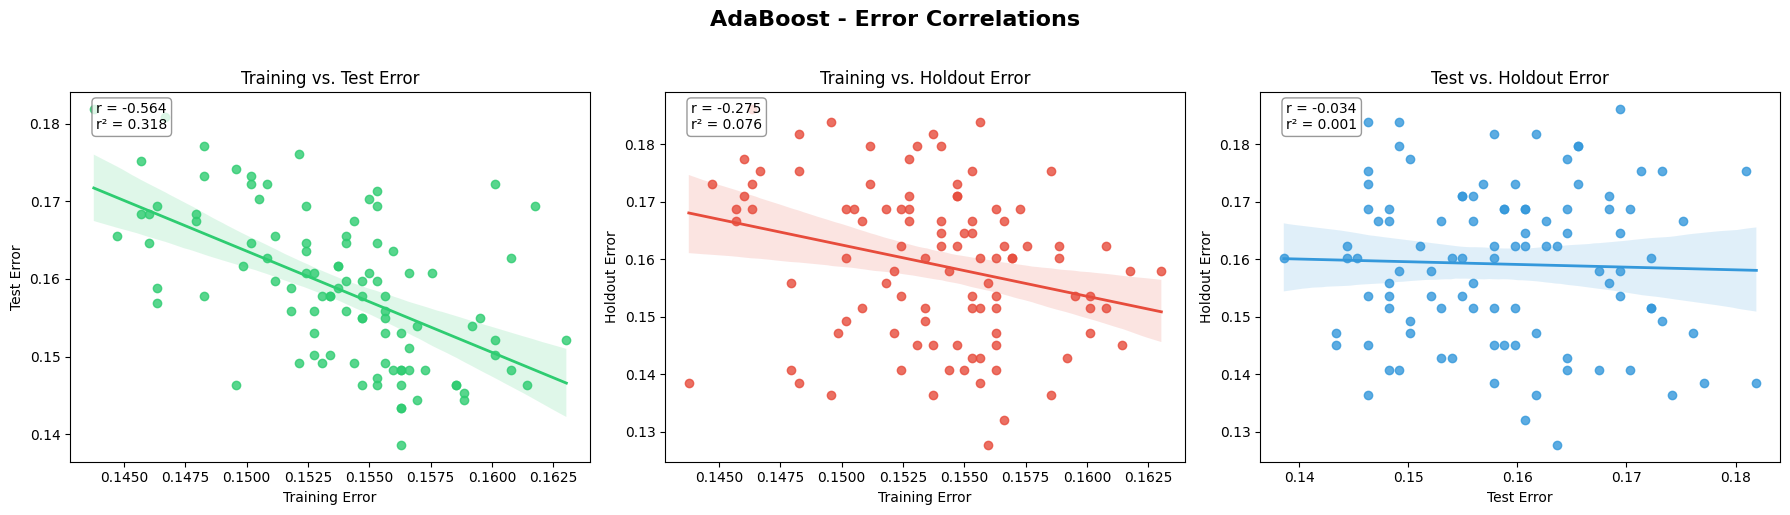


AdaBoost - Correlation Summary:
  Training vs Test:    r = -0.564, r² = 0.318, p = 1.035e-09
  Training vs Holdout: r = -0.275, r² = 0.076, p = 5.583e-03
  Test vs Holdout:     r = -0.034, r² = 0.001, p = 7.402e-01


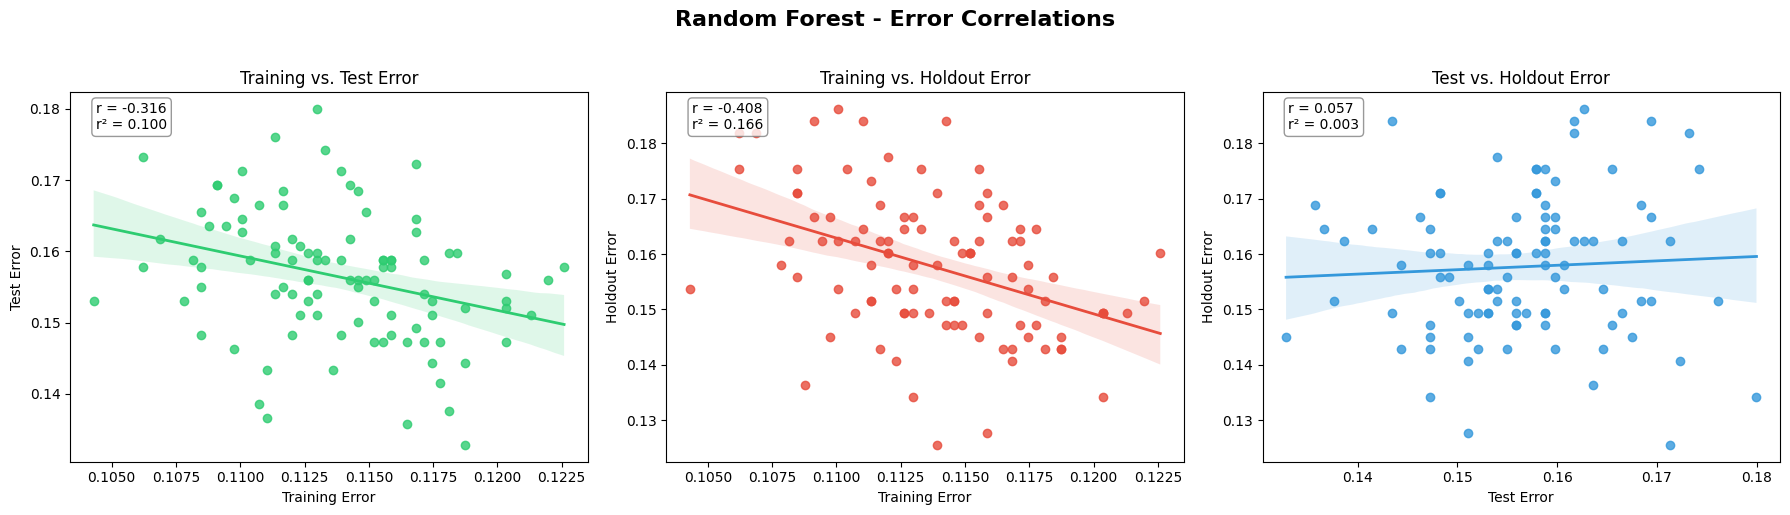


Random Forest - Correlation Summary:
  Training vs Test:    r = -0.316, r² = 0.100, p = 1.356e-03
  Training vs Holdout: r = -0.408, r² = 0.166, p = 2.520e-05
  Test vs Holdout:     r = 0.057, r² = 0.003, p = 5.710e-01


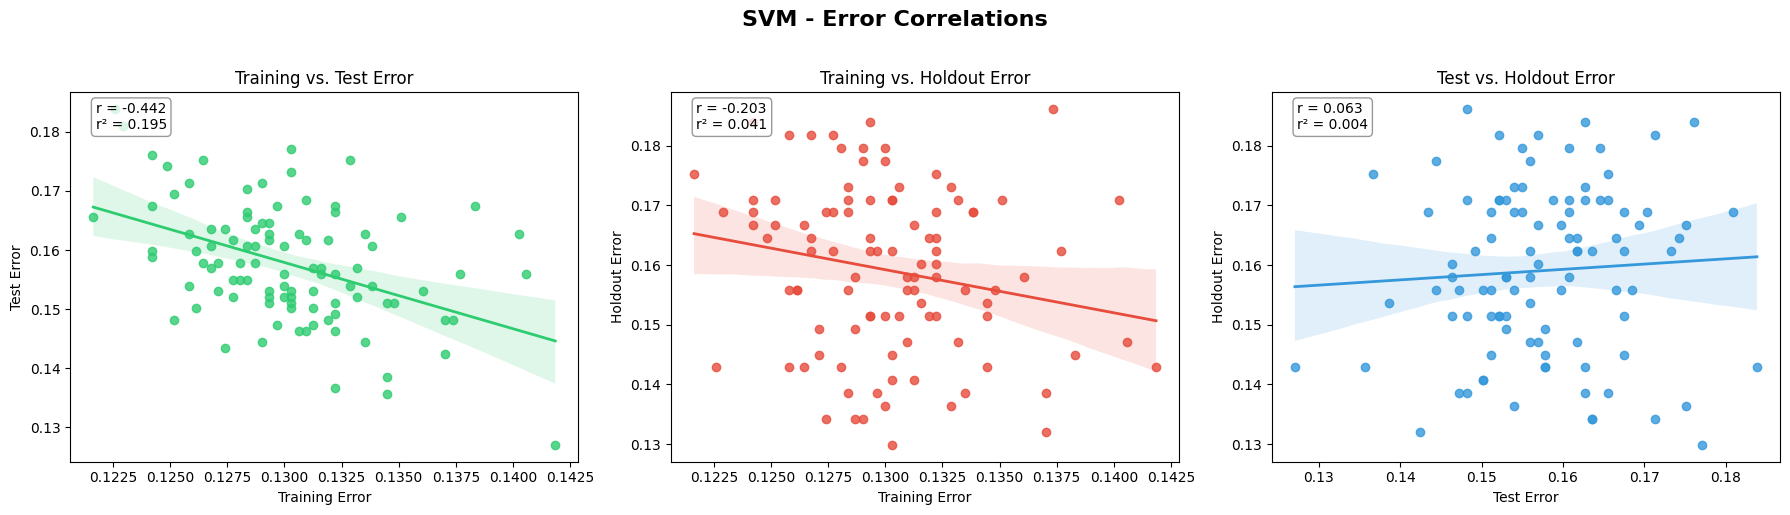


SVM - Correlation Summary:
  Training vs Test:    r = -0.442, r² = 0.195, p = 4.249e-06
  Training vs Holdout: r = -0.203, r² = 0.041, p = 4.246e-02
  Test vs Holdout:     r = 0.063, r² = 0.004, p = 5.335e-01


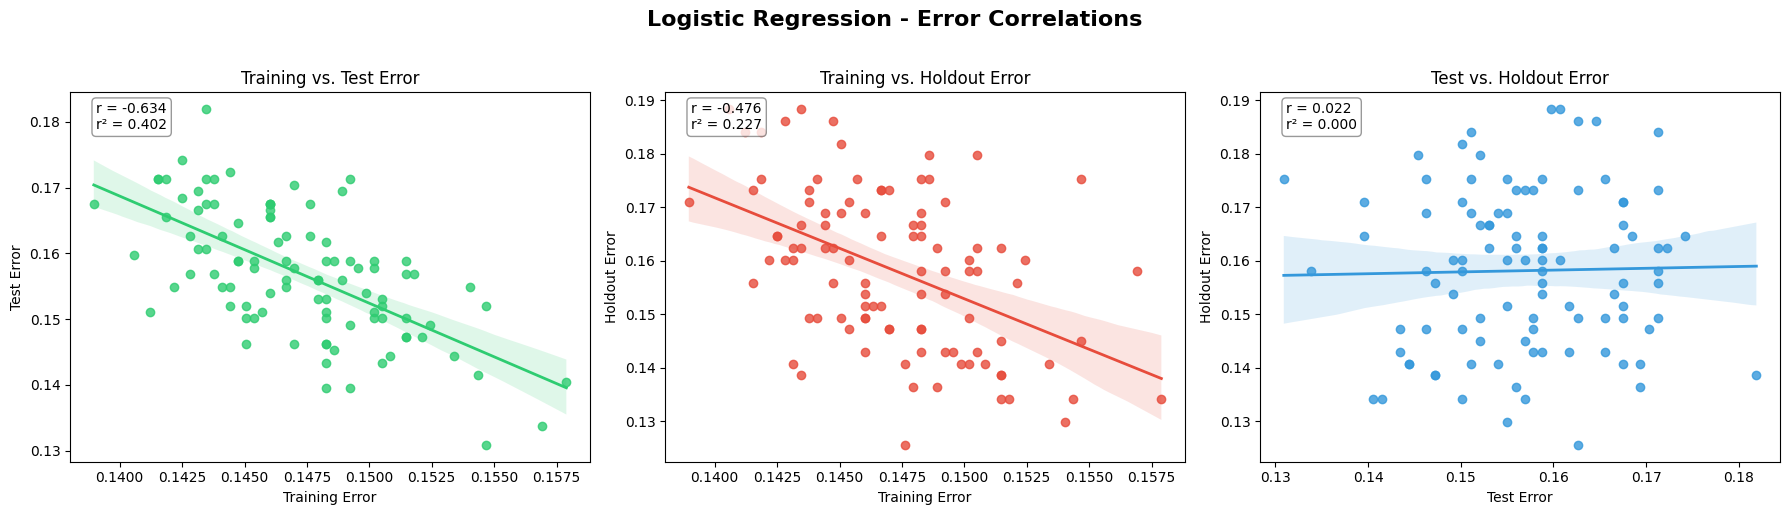


Logistic Regression - Correlation Summary:
  Training vs Test:    r = -0.634, r² = 0.402, p = 1.375e-12
  Training vs Holdout: r = -0.476, r² = 0.227, p = 5.495e-07
  Test vs Holdout:     r = 0.022, r² = 0.000, p = 8.290e-01


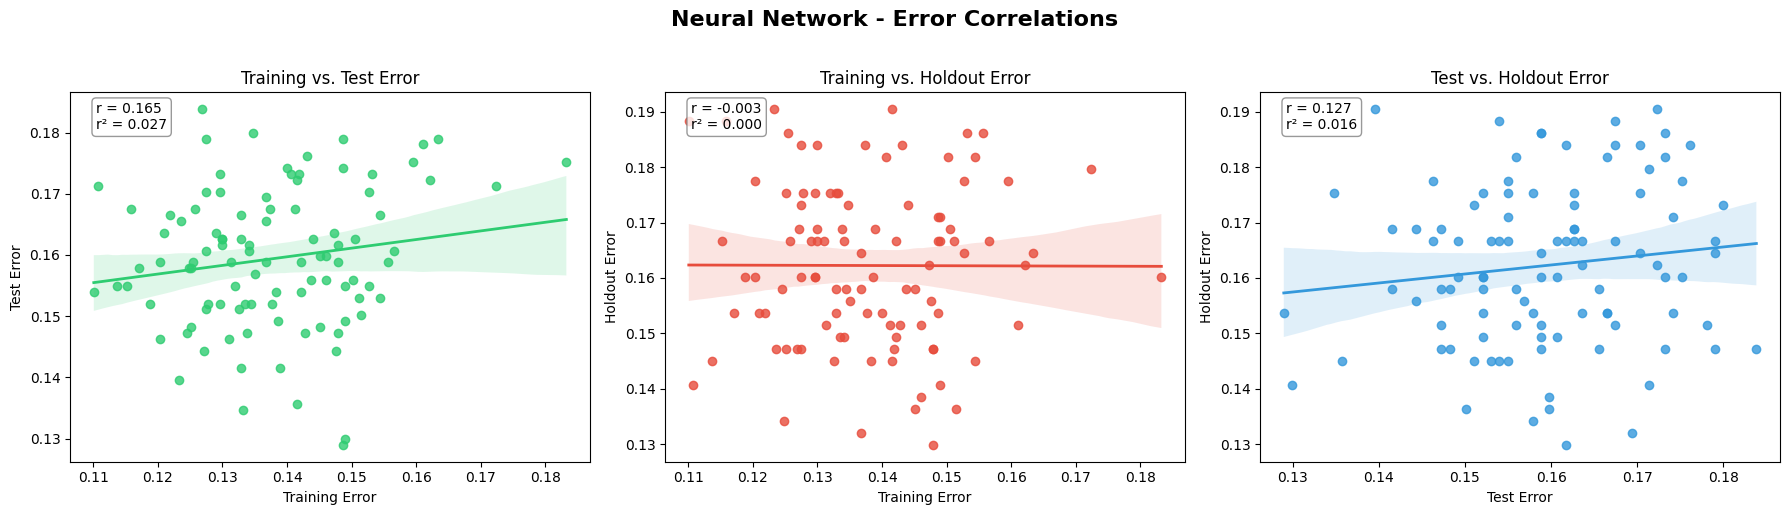


Neural Network - Correlation Summary:
  Training vs Test:    r = 0.165, r² = 0.027, p = 1.003e-01
  Training vs Holdout: r = -0.003, r² = 0.000, p = 9.766e-01
  Test vs Holdout:     r = 0.127, r² = 0.016, p = 2.078e-01

Creating correlation analysis...

CORRELATION SUMMARY TABLE
          Algorithm  Train-Test r  Train-Test r²  Train-Test p  Train-Holdout r  Train-Holdout r²  Train-Holdout p  Test-Holdout r  Test-Holdout r²  Test-Holdout p
           AdaBoost       -0.5635         0.3175        0.0000          -0.2752            0.0757           0.0056         -0.0336           0.0011          0.7402
      Random Forest       -0.3161         0.0999        0.0014          -0.4079            0.1664           0.0000          0.0573           0.0033          0.5710
                SVM       -0.4416         0.1950        0.0000          -0.2033            0.0413           0.0425          0.0630           0.0040          0.5335
Logistic Regression       -0.6344         0.4025        0.0000 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

def create_algorithm_specific_plots(results_df):
    """
    Create separate error comparison plots for each algorithm, mimicking the provided style

    Parameters:
    results_df: DataFrame with columns ['Algorithm', 'Training Error', 'Test Error', 'Holdout Error']
    """
    # Define custom colors (same as the original)
    custom_colors = ["#2ecc71",  # Green
                     "#e74c3c",  # Red
                     "#3498db",  # Blue
                     "#9b59b6"]  # Purple

    # Get unique algorithms
    algorithms = results_df['Algorithm'].unique()

    # Create plots for each algorithm
    for i, algorithm in enumerate(algorithms):
        # Filter data for current algorithm
        algo_df = results_df[results_df['Algorithm'] == algorithm].copy()

        # Set figure size for a row of 3 plots
        plt.figure(figsize=(18, 5))

        # Set the color palette
        sns.set_palette(custom_colors)

        # First plot: Training vs Test Error
        plt.subplot(1, 3, 1)
        # Calculate correlation coefficient (R) and p-value
        r_train_test, p_train_test = stats.pearsonr(algo_df['Training Error'], algo_df['Test Error'])
        r2_train_test = r_train_test**2
        # Add regression plot
        sns.regplot(data=algo_df, x='Training Error', y='Test Error',
                    scatter_kws={'color': custom_colors[0]},
                    line_kws={'color': custom_colors[0], 'linewidth': 2})
        # Add R and R² text
        plt.annotate(f'r = {r_train_test:.3f}\nr² = {r2_train_test:.3f}',
                     xy=(0.05, 0.90), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        plt.title('Training vs. Test Error')
        plt.xlabel('Training Error')
        plt.ylabel('Test Error')

        # Second plot: Training vs Holdout Error
        plt.subplot(1, 3, 2)
        # Calculate correlation coefficient (R) and p-value
        r_train_holdout, p_train_holdout = stats.pearsonr(algo_df['Training Error'], algo_df['Holdout Error'])
        r2_train_holdout = r_train_holdout**2
        # Add regression plot
        sns.regplot(data=algo_df, x='Training Error', y='Holdout Error',
                    scatter_kws={'color': custom_colors[1]},
                    line_kws={'color': custom_colors[1], 'linewidth': 2})
        # Add R and R² text
        plt.annotate(f'r = {r_train_holdout:.3f}\nr² = {r2_train_holdout:.3f}',
                     xy=(0.05, 0.90), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        plt.title('Training vs. Holdout Error')
        plt.xlabel('Training Error')
        plt.ylabel('Holdout Error')

        # Third plot: Test vs Holdout Error
        plt.subplot(1, 3, 3)
        # Calculate correlation coefficient (R) and p-value
        r_test_holdout, p_test_holdout = stats.pearsonr(algo_df['Test Error'], algo_df['Holdout Error'])
        r2_test_holdout = r_test_holdout**2
        # Add regression plot
        sns.regplot(data=algo_df, x='Test Error', y='Holdout Error',
                    scatter_kws={'color': custom_colors[2]},
                    line_kws={'color': custom_colors[2], 'linewidth': 2})
        # Add R and R² text
        plt.annotate(f'r = {r_test_holdout:.3f}\nr² = {r2_test_holdout:.3f}',
                     xy=(0.05, 0.90), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        plt.title('Test vs. Holdout Error')
        plt.xlabel('Test Error')
        plt.ylabel('Holdout Error')

        # Add main title for the algorithm
        plt.suptitle(f'{algorithm} - Error Correlations', fontsize=16, fontweight='bold', y=1.02)

        # Adjust layout to prevent overlap
        plt.tight_layout()

        # Save individual plots
        plt.savefig(f'{algorithm.replace(" ", "_")}_error_correlations.png',
                   dpi=300, bbox_inches='tight')

        # Show the plots
        plt.show()

        # Print correlation summary for this algorithm
        print(f"\n{algorithm} - Correlation Summary:")
        print(f"  Training vs Test:    r = {r_train_test:.3f}, r² = {r2_train_test:.3f}, p = {p_train_test:.3e}")
        print(f"  Training vs Holdout: r = {r_train_holdout:.3f}, r² = {r2_train_holdout:.3f}, p = {p_train_holdout:.3e}")
        print(f"  Test vs Holdout:     r = {r_test_holdout:.3f}, r² = {r2_test_holdout:.3f}, p = {p_test_holdout:.3e}")

def create_summary_correlation_table(results_df):
    """
    Create a summary table of all correlations across algorithms
    """
    algorithms = results_df['Algorithm'].unique()
    correlation_summary = []

    for algorithm in algorithms:
        algo_df = results_df[results_df['Algorithm'] == algorithm].copy()

        # Calculate correlations
        r_train_test, p_train_test = stats.pearsonr(algo_df['Training Error'], algo_df['Test Error'])
        r_train_holdout, p_train_holdout = stats.pearsonr(algo_df['Training Error'], algo_df['Holdout Error'])
        r_test_holdout, p_test_holdout = stats.pearsonr(algo_df['Test Error'], algo_df['Holdout Error'])

        correlation_summary.append({
            'Algorithm': algorithm,
            'Train-Test r': r_train_test,
            'Train-Test r²': r_train_test**2,
            'Train-Test p': p_train_test,
            'Train-Holdout r': r_train_holdout,
            'Train-Holdout r²': r_train_holdout**2,
            'Train-Holdout p': p_train_holdout,
            'Test-Holdout r': r_test_holdout,
            'Test-Holdout r²': r_test_holdout**2,
            'Test-Holdout p': p_test_holdout
        })

    correlation_df = pd.DataFrame(correlation_summary)

    print("\n" + "="*80)
    print("CORRELATION SUMMARY TABLE")
    print("="*80)
    print(correlation_df.round(4).to_string(index=False))

    return correlation_df

def analyze_correlation_patterns(results_df):
    """
    Analyze patterns in correlations across algorithms
    """
    correlation_df = create_summary_correlation_table(results_df)

    print("\n" + "="*60)
    print("CORRELATION ANALYSIS")
    print("="*60)

    # Find algorithm with highest/lowest correlations
    print(f"\nHighest Train-Test correlation: {correlation_df.loc[correlation_df['Train-Test r'].idxmax(), 'Algorithm']} "
          f"(r = {correlation_df['Train-Test r'].max():.3f})")
    print(f"Lowest Train-Test correlation:  {correlation_df.loc[correlation_df['Train-Test r'].idxmin(), 'Algorithm']} "
          f"(r = {correlation_df['Train-Test r'].min():.3f})")

    print(f"\nHighest Train-Holdout correlation: {correlation_df.loc[correlation_df['Train-Holdout r'].idxmax(), 'Algorithm']} "
          f"(r = {correlation_df['Train-Holdout r'].max():.3f})")
    print(f"Lowest Train-Holdout correlation:  {correlation_df.loc[correlation_df['Train-Holdout r'].idxmin(), 'Algorithm']} "
          f"(r = {correlation_df['Train-Holdout r'].min():.3f})")

    print(f"\nHighest Test-Holdout correlation: {correlation_df.loc[correlation_df['Test-Holdout r'].idxmax(), 'Algorithm']} "
          f"(r = {correlation_df['Test-Holdout r'].max():.3f})")
    print(f"Lowest Test-Holdout correlation:  {correlation_df.loc[correlation_df['Test-Holdout r'].idxmin(), 'Algorithm']} "
          f"(r = {correlation_df['Test-Holdout r'].min():.3f})")

    # Interpretation guide
    print(f"\n" + "="*60)
    print("INTERPRETATION GUIDE")
    print("="*60)
    print("• High Train-Test correlation suggests consistent overfitting patterns")
    print("• Low Train-Holdout correlation may indicate unstable generalization")
    print("• High Test-Holdout correlation suggests good validation set reliability")
    print("• r² values show proportion of variance explained by the relationship")

    return correlation_df

# Example usage and main execution
if __name__ == "__main__":
    # Try to load results from CSV
    try:
        results_df = adult_df
        print("Loaded results from CSV file")
        print(f"Found {len(results_df)} results for {len(results_df['Algorithm'].unique())} algorithms")

        # Create algorithm-specific plots
        print("\nCreating algorithm-specific error correlation plots...")
        create_algorithm_specific_plots(results_df)

        # Create summary analysis
        print("\nCreating correlation analysis...")
        correlation_summary = analyze_correlation_patterns(results_df)

    except FileNotFoundError:
        print("No results file found. Please run the main experiment first.")
        print("Expected file: 'multi_algorithm_results.csv'")

        # Create sample data for demonstration
        print("\nCreating sample visualization with dummy data...")
        np.random.seed(42)
        algorithms = ['AdaBoost', 'Random Forest', 'SVM', 'Logistic Regression', 'Neural Network']
        sample_data = []

        for algo in algorithms:
            # Create different correlation patterns for each algorithm
            base_error = np.random.uniform(0.15, 0.25)

            for seed in range(50):  # More points for better correlation analysis
                if algo == 'AdaBoost':
                    # High correlation between train and test
                    train_err = np.random.uniform(0.1, 0.2)
                    test_err = train_err + np.random.normal(0.05, 0.02)
                    holdout_err = train_err + np.random.normal(0.06, 0.025)
                elif algo == 'Random Forest':
                    # Lower training error, moderate correlation
                    train_err = np.random.uniform(0.05, 0.15)
                    test_err = train_err + np.random.normal(0.08, 0.03)
                    holdout_err = test_err + np.random.normal(0.01, 0.02)
                elif algo == 'SVM':
                    # More consistent across all error types
                    base = np.random.uniform(0.15, 0.25)
                    train_err = base + np.random.normal(0, 0.01)
                    test_err = base + np.random.normal(0.02, 0.015)
                    holdout_err = base + np.random.normal(0.025, 0.02)
                elif algo == 'Logistic Regression':
                    # Linear relationship between errors
                    train_err = np.random.uniform(0.12, 0.22)
                    test_err = train_err * 1.1 + np.random.normal(0.01, 0.01)
                    holdout_err = train_err * 1.12 + np.random.normal(0.015, 0.015)
                else:  # Neural Network
                    # More variable, some overfitting
                    train_err = np.random.uniform(0.08, 0.18)
                    test_err = train_err + np.random.exponential(0.05)
                    holdout_err = train_err + np.random.exponential(0.06)

                # Ensure errors are positive and reasonable
                train_err = max(0.01, min(0.5, train_err))
                test_err = max(0.01, min(0.5, test_err))
                holdout_err = max(0.01, min(0.5, holdout_err))

                sample_data.append({
                    'Algorithm': algo,
                    'Seed': seed,
                    'Training Error': train_err,
                    'Test Error': test_err,
                    'Holdout Error': holdout_err
                })

        #sample_df = pd.DataFrame(sample_data)
        #print("Created sample data with realistic correlation patterns")

        # Create the visualizations with sample data
        create_algorithm_specific_plots(adult_df)
        analyze_correlation_patterns(adult_df)

## Interpretation of Results (UCI Adult)

#### Here we see the anti-correlation phenomena clearly present in all models but NN, despite the large data set we are processing; indicating that the α factor may be large to give this strong of an effect. We also see the secondary effect of mild effect of anti-correlation in the Training vs. Holdout plot, suggesting that this model is prone to overfitting.

In [ ]:
# Define all algorithms to test
def get_algorithms():
    """
    Define the algorithms to compare
    """
    base_learner = DecisionTreeClassifier(max_depth=1)

    algorithms = {
        'AdaBoost': AdaBoostClassifier(
            estimator=base_learner,
            n_estimators=50,
            random_state=42
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42
        ),
        'SVM': SVC(
            kernel='rbf',
            C=1.0,
            random_state=42
        ),
        'Logistic Regression': LogisticRegression(
            max_iter=1000,
            random_state=42
        ),
        'Neural Network': MLPClassifier(
            hidden_layer_sizes=(100, 50),
            max_iter=300,
            random_state=42,
            early_stopping=True,
            validation_fraction=0.1
        )
    }

    return algorithms

# Run cross-validation experiment for all algorithms
def run_multi_algorithm_experiment(X, y, preprocessor, n_runs=100):
    """
    Run the experiment with multiple algorithms using the same CV setup
    """
    algorithms = get_algorithms()
    results = []

    for seed in range(n_runs):
        # Split into train-val and holdout sets
        X_train_val, X_holdout, y_train_val, y_holdout = train_test_split(
            X, y, test_size=0.1, random_state=seed, stratify=y)

        # Further split train-val into train and test
        X_train, X_test, y_train, y_test = train_test_split(
            X_train_val, y_train_val, test_size=0.25, random_state=seed, stratify=y_train_val)

        # Test each algorithm
        for algo_name, algorithm in algorithms.items():
            # Create pipeline with the current algorithm
            # Note: We need to create a fresh copy of the algorithm for each run
            if algo_name == 'AdaBoost':
                base_learner = DecisionTreeClassifier(max_depth=1)
                current_algo = AdaBoostClassifier(
                    estimator=base_learner,
                    n_estimators=50,
                    random_state=seed
                )
            elif algo_name == 'Random Forest':
                current_algo = RandomForestClassifier(
                    n_estimators=100,
                    max_depth=10,
                    random_state=seed
                )
            elif algo_name == 'SVM':
                current_algo = SVC(
                    kernel='rbf',
                    C=1.0,
                    random_state=seed
                )
            elif algo_name == 'Logistic Regression':
                current_algo = LogisticRegression(
                    max_iter=1000,
                    random_state=seed
                )
            elif algo_name == 'Neural Network':
                current_algo = MLPClassifier(
                    hidden_layer_sizes=(100, 50),
                    max_iter=300,
                    random_state=seed,
                    early_stopping=True,
                    validation_fraction=0.1
                )

            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', current_algo)
            ])

            # Train the pipeline
            pipeline.fit(X_train, y_train)

            # Calculate errors
            train_error = 1 - accuracy_score(y_train, pipeline.predict(X_train))
            test_error = 1 - accuracy_score(y_test, pipeline.predict(X_test))
            holdout_error = 1 - accuracy_score(y_holdout, pipeline.predict(X_holdout))

            results.append({
                'Algorithm': algo_name,
                'Seed': seed,
                'Training Error': train_error,
                'Test Error': test_error,
                'Holdout Error': holdout_error
            })

        # Print progress every 10 runs
        if (seed + 1) % 10 == 0:
            print(f"Completed {seed + 1}/{n_runs} runs")

    return pd.DataFrame(results)



# Main execution
if __name__ == "__main__":
    print("Loading Adult dataset...")
    adult_data = load_adult_data()
    adult_data = adult_data.sample(n=5000, random_state=42)

    print(f"Dataset shape: {adult_data.shape}")

    # Optional: Sample the data to speed up computation
    # Uncomment the next line to use a smaller sample for faster testing
    # adult_data = adult_data.sample(n=5000, random_state=42)

    print("Preprocessing data...")
    X, y, preprocessor = preprocess_adult_data(adult_data)
    print(f"Preprocessed data shape: {X.shape}")
    print(f"Class distribution: {y.value_counts().to_dict()}")

    print("\nStarting multi-algorithm experiment...")
    print("This may take several minutes...")

    # Run the experiment with fewer runs for demonstration
    # Change n_runs to 100 for full experiment
    adult_df = run_multi_algorithm_experiment(X, y, preprocessor, n_runs=100)



##Analysis of UCI Heart Disease

#### Data set with features trying to predict whether or not a patient has heart disease or not. Same process as above for CV procedure.

## Relevant Feature Info
#### - Small Data set ~ 300 instances
#### - Binary classification task (more susceptible to overfitting)
#### - 73 features

In [ ]:
def load_heart_disease_data():
    """
    Download and prepare the UCI Heart Disease dataset
    """
    # URL for the Heart Disease dataset
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

    # Column names for the dataset
    column_names = [
        'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
    ]

    # Load the data
    data = pd.read_csv(url, names=column_names, na_values='?')

    # Convert the target column to binary (0 = no disease, 1 = disease)
    # In the original data, 0 is no disease and 1-4 indicates disease of varying severity
    data['target'] = data['target'].apply(lambda x: 0 if x == 0 else 1)

    return data

# Function to preprocess the Heart Disease dataset
def preprocess_heart_data(data):
    """
    Preprocess the Heart Disease dataset for machine learning
    """
    # Drop rows with missing values for simplicity
    data = data.dropna()

    # Split features and target
    X = data.drop('target', axis=1)
    y = data['target']

    # Identify numeric and categorical columns
    # For the heart dataset, 'ca' and 'thal' are categorical despite being numeric
    numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

    # Define preprocessing for numerical and categorical features
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    # Create preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    return X, y, preprocessor

# Define all algorithms to test
def get_algorithms():
    """
    Define the algorithms to compare
    """
    base_learner = DecisionTreeClassifier(max_depth=1)

    algorithms = {
        'AdaBoost': AdaBoostClassifier(
            estimator=base_learner,
            n_estimators=50,
            random_state=42
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42
        ),
        'SVM': SVC(
            kernel='rbf',
            C=1.0,
            random_state=42
        ),
        'Logistic Regression': LogisticRegression(
            max_iter=1000,
            random_state=42
        ),
        'Neural Network': MLPClassifier(
            hidden_layer_sizes=(100, 50),
            max_iter=300,
            random_state=42,
            early_stopping=True,
            validation_fraction=0.1
        )
    }

    return algorithms

# Run cross-validation experiment for all algorithms
def run_multi_algorithm_experiment(X, y, preprocessor, n_runs=100):
    """
    Run the experiment with multiple algorithms using the same CV setup
    """
    algorithms = get_algorithms()
    results = []

    for seed in range(n_runs):
        # Split into train-val and holdout sets
        X_train_val, X_holdout, y_train_val, y_holdout = train_test_split(
            X, y, test_size=0.1, random_state=seed, stratify=y)

        # Further split train-val into train and test
        X_train, X_test, y_train, y_test = train_test_split(
            X_train_val, y_train_val, test_size=0.25, random_state=seed, stratify=y_train_val)

        # Test each algorithm
        for algo_name, algorithm in algorithms.items():
            # Create pipeline with the current algorithm
            # Note: We need to create a fresh copy of the algorithm for each run
            if algo_name == 'AdaBoost':
                base_learner = DecisionTreeClassifier(max_depth=1)
                current_algo = AdaBoostClassifier(
                    estimator=base_learner,
                    n_estimators=50,
                    random_state=seed
                )
            elif algo_name == 'Random Forest':
                current_algo = RandomForestClassifier(
                    n_estimators=100,
                    max_depth=10,
                    random_state=seed
                )
            elif algo_name == 'SVM':
                current_algo = SVC(
                    kernel='rbf',
                    C=1.0,
                    random_state=seed
                )
            elif algo_name == 'Logistic Regression':
                current_algo = LogisticRegression(
                    max_iter=1000,
                    random_state=seed
                )
            elif algo_name == 'Neural Network':
                current_algo = MLPClassifier(
                    hidden_layer_sizes=(100, 50),
                    max_iter=300,
                    random_state=seed,
                    early_stopping=True,
                    validation_fraction=0.1
                )

            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', current_algo)
            ])

            # Train the pipeline
            pipeline.fit(X_train, y_train)

            # Calculate errors
            train_error = 1 - accuracy_score(y_train, pipeline.predict(X_train))
            test_error = 1 - accuracy_score(y_test, pipeline.predict(X_test))
            holdout_error = 1 - accuracy_score(y_holdout, pipeline.predict(X_holdout))

            results.append({
                'Algorithm': algo_name,
                'Seed': seed,
                'Training Error': train_error,
                'Test Error': test_error,
                'Holdout Error': holdout_error
            })

        # Print progress every 10 runs
        if (seed + 1) % 10 == 0:
            print(f"Completed {seed + 1}/{n_runs} runs")

    return pd.DataFrame(results)



# Main execution
if __name__ == "__main__":
    print("Loading Adult dataset...")
    heart_data = load_heart_disease_data()

    print(f"Dataset shape: {heart_data.shape}")

    # Optional: Sample the data to speed up computation
    # Uncomment the next line to use a smaller sample for faster testing
    # adult_data = adult_data.sample(n=5000, random_state=42)

    print("Preprocessing data...")
    X, y, preprocessor = preprocess_heart_data(heart_data)
    print(f"Preprocessed data shape: {X.shape}")
    print(f"Class distribution: {y.value_counts().to_dict()}")

    print("\nStarting multi-algorithm experiment...")
    print("This may take several minutes...")

    # Run the experiment with fewer runs for demonstration
    # Change n_runs to 100 for full experiment
    heart_df = run_multi_algorithm_experiment(X, y, preprocessor, n_runs=100)




Loading Adult dataset...
Dataset shape: (303, 14)
Preprocessing data...
Preprocessed data shape: (297, 13)
Class distribution: {0: 160, 1: 137}

Starting multi-algorithm experiment...
This may take several minutes...
Completed 10/100 runs
Completed 20/100 runs
Completed 30/100 runs
Completed 40/100 runs
Completed 50/100 runs
Completed 60/100 runs
Completed 70/100 runs
Completed 80/100 runs
Completed 90/100 runs
Completed 100/100 runs


## Visualization of UCI Heart Disease

Loaded results from CSV file
Found 500 results for 5 algorithms

Creating algorithm-specific error correlation plots...


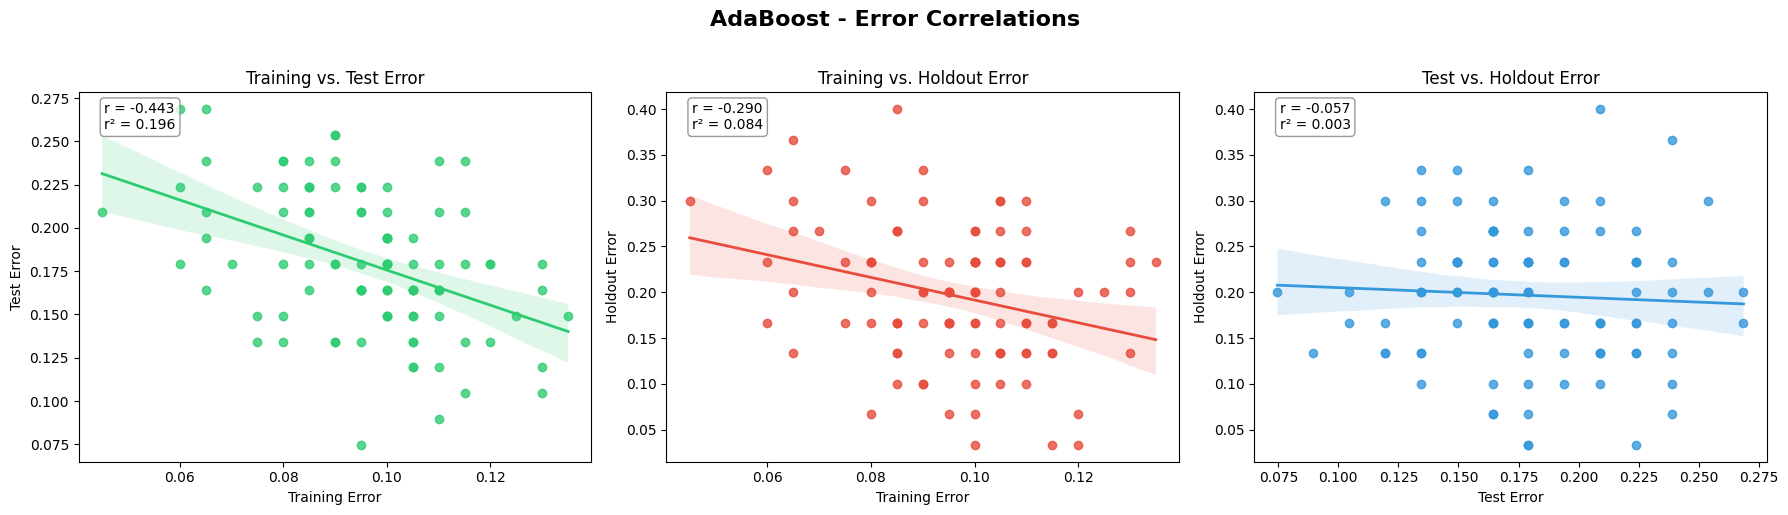


AdaBoost - Correlation Summary:
  Training vs Test:    r = -0.443, r² = 0.196, p = 4.017e-06
  Training vs Holdout: r = -0.290, r² = 0.084, p = 3.446e-03
  Test vs Holdout:     r = -0.057, r² = 0.003, p = 5.754e-01


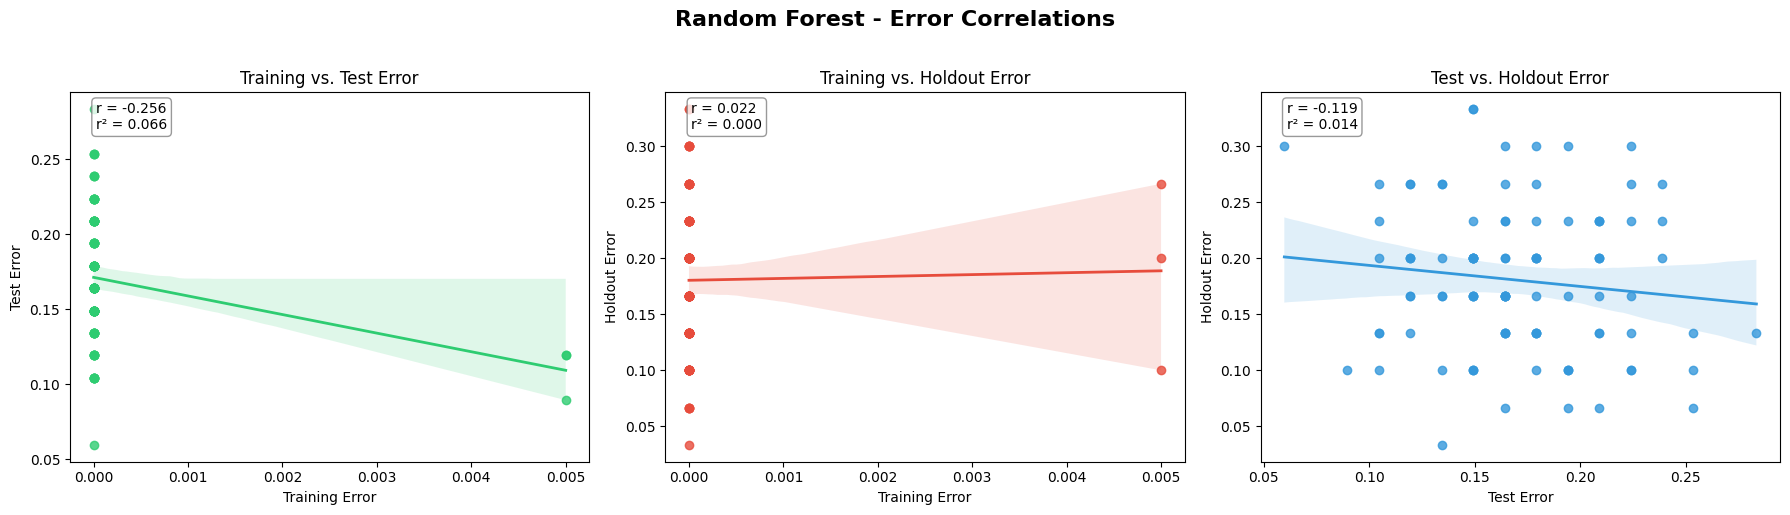


Random Forest - Correlation Summary:
  Training vs Test:    r = -0.256, r² = 0.066, p = 1.004e-02
  Training vs Holdout: r = 0.022, r² = 0.000, p = 8.257e-01
  Test vs Holdout:     r = -0.119, r² = 0.014, p = 2.370e-01


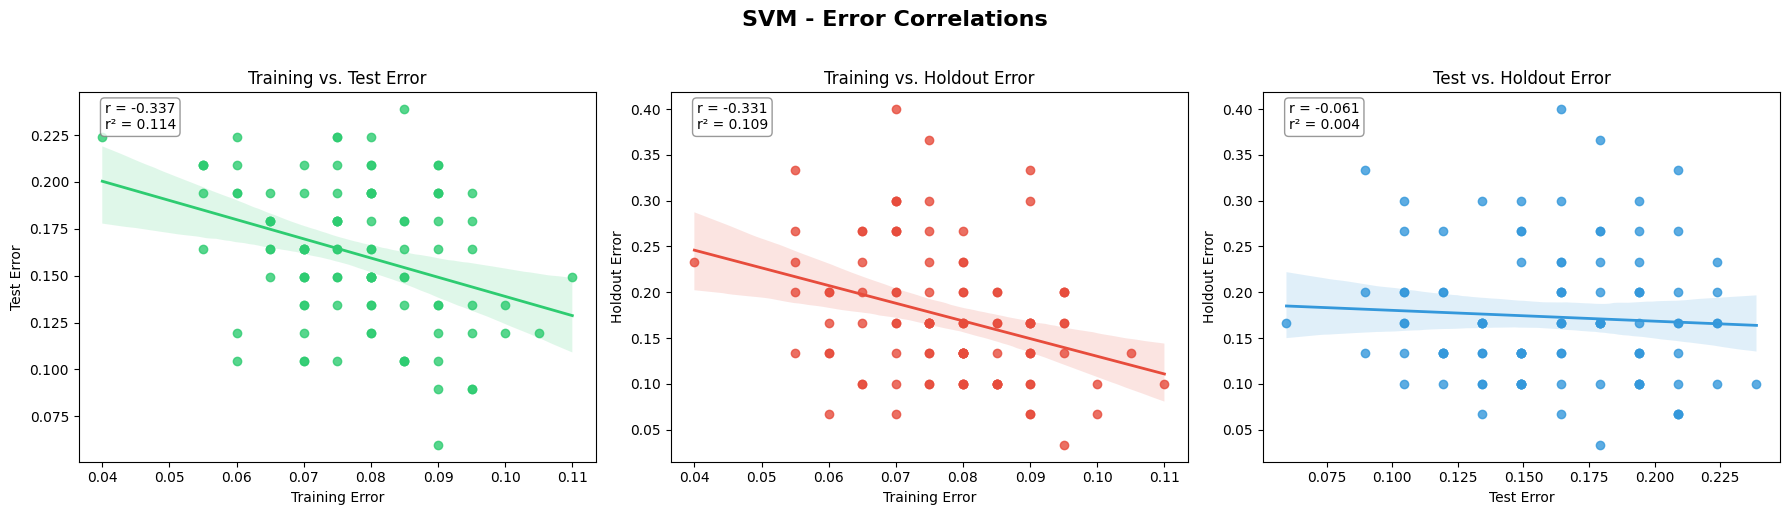


SVM - Correlation Summary:
  Training vs Test:    r = -0.337, r² = 0.114, p = 6.036e-04
  Training vs Holdout: r = -0.331, r² = 0.109, p = 7.799e-04
  Test vs Holdout:     r = -0.061, r² = 0.004, p = 5.437e-01


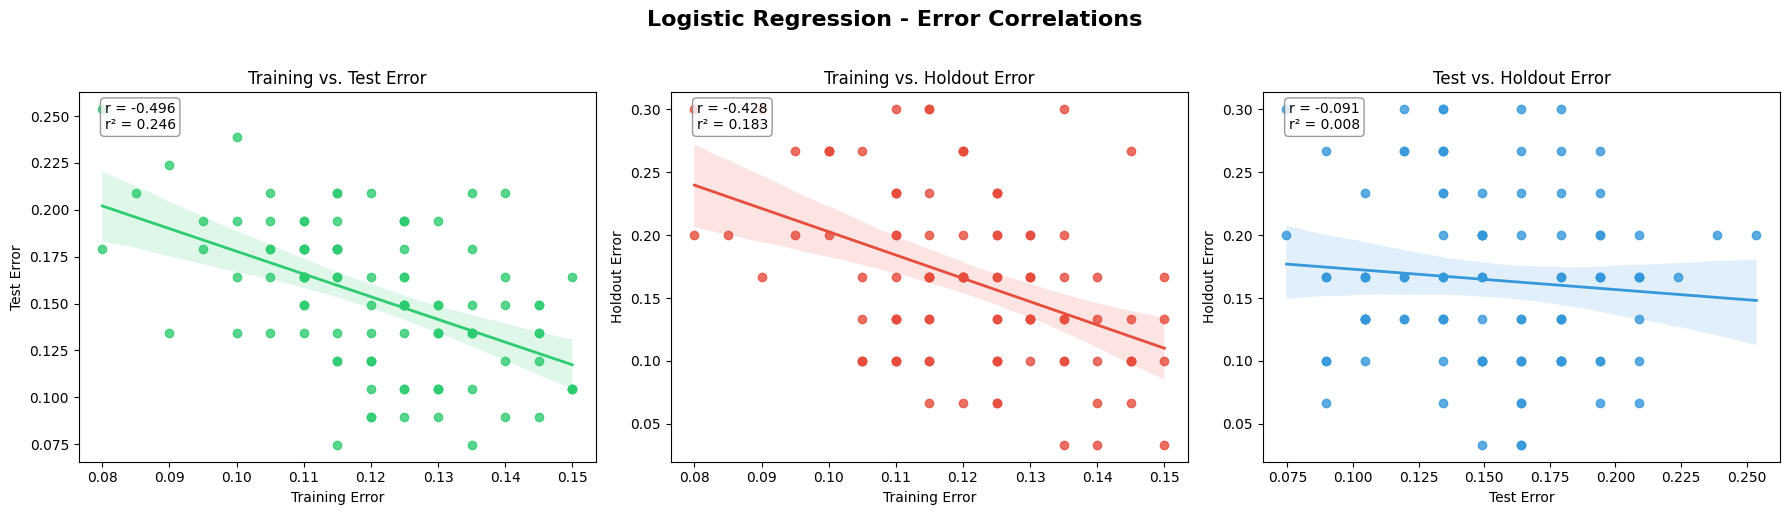


Logistic Regression - Correlation Summary:
  Training vs Test:    r = -0.496, r² = 0.246, p = 1.517e-07
  Training vs Holdout: r = -0.428, r² = 0.183, p = 9.004e-06
  Test vs Holdout:     r = -0.091, r² = 0.008, p = 3.674e-01


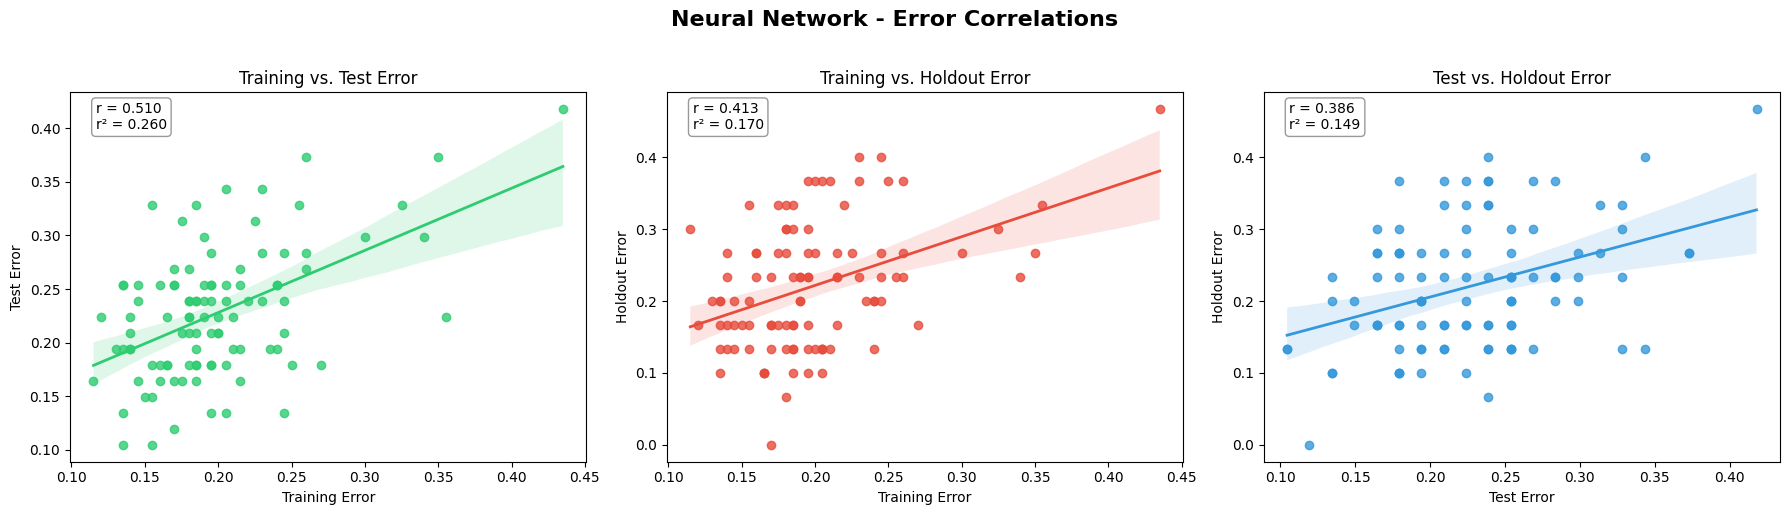


Neural Network - Correlation Summary:
  Training vs Test:    r = 0.510, r² = 0.260, p = 6.042e-08
  Training vs Holdout: r = 0.413, r² = 0.170, p = 1.969e-05
  Test vs Holdout:     r = 0.386, r² = 0.149, p = 7.392e-05

Creating correlation analysis...

CORRELATION SUMMARY TABLE
          Algorithm  Train-Test r  Train-Test r²  Train-Test p  Train-Holdout r  Train-Holdout r²  Train-Holdout p  Test-Holdout r  Test-Holdout r²  Test-Holdout p
           AdaBoost       -0.4426         0.1959        0.0000          -0.2898            0.0840           0.0034         -0.0567           0.0032          0.5754
      Random Forest       -0.2564         0.0657        0.0100           0.0223            0.0005           0.8257         -0.1193           0.0142          0.2370
                SVM       -0.3371         0.1137        0.0006          -0.3306            0.1093           0.0008         -0.0614           0.0038          0.5437
Logistic Regression       -0.4962         0.2463        0.0000  

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

def create_algorithm_specific_plots(results_df):
    """
    Create separate error comparison plots for each algorithm, mimicking the provided style

    Parameters:
    results_df: DataFrame with columns ['Algorithm', 'Training Error', 'Test Error', 'Holdout Error']
    """
    # Define custom colors (same as the original)
    custom_colors = ["#2ecc71",  # Green
                     "#e74c3c",  # Red
                     "#3498db",  # Blue
                     "#9b59b6"]  # Purple

    # Get unique algorithms
    algorithms = results_df['Algorithm'].unique()

    # Create plots for each algorithm
    for i, algorithm in enumerate(algorithms):
        # Filter data for current algorithm
        algo_df = results_df[results_df['Algorithm'] == algorithm].copy()

        # Set figure size for a row of 3 plots
        plt.figure(figsize=(18, 5))

        # Set the color palette
        sns.set_palette(custom_colors)

        # First plot: Training vs Test Error
        plt.subplot(1, 3, 1)
        # Calculate correlation coefficient (R) and p-value
        r_train_test, p_train_test = stats.pearsonr(algo_df['Training Error'], algo_df['Test Error'])
        r2_train_test = r_train_test**2
        # Add regression plot
        sns.regplot(data=algo_df, x='Training Error', y='Test Error',
                    scatter_kws={'color': custom_colors[0]},
                    line_kws={'color': custom_colors[0], 'linewidth': 2})
        # Add R and R² text
        plt.annotate(f'r = {r_train_test:.3f}\nr² = {r2_train_test:.3f}',
                     xy=(0.05, 0.90), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        plt.title('Training vs. Test Error')
        plt.xlabel('Training Error')
        plt.ylabel('Test Error')

        # Second plot: Training vs Holdout Error
        plt.subplot(1, 3, 2)
        # Calculate correlation coefficient (R) and p-value
        r_train_holdout, p_train_holdout = stats.pearsonr(algo_df['Training Error'], algo_df['Holdout Error'])
        r2_train_holdout = r_train_holdout**2
        # Add regression plot
        sns.regplot(data=algo_df, x='Training Error', y='Holdout Error',
                    scatter_kws={'color': custom_colors[1]},
                    line_kws={'color': custom_colors[1], 'linewidth': 2})
        # Add R and R² text
        plt.annotate(f'r = {r_train_holdout:.3f}\nr² = {r2_train_holdout:.3f}',
                     xy=(0.05, 0.90), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        plt.title('Training vs. Holdout Error')
        plt.xlabel('Training Error')
        plt.ylabel('Holdout Error')

        # Third plot: Test vs Holdout Error
        plt.subplot(1, 3, 3)
        # Calculate correlation coefficient (R) and p-value
        r_test_holdout, p_test_holdout = stats.pearsonr(algo_df['Test Error'], algo_df['Holdout Error'])
        r2_test_holdout = r_test_holdout**2
        # Add regression plot
        sns.regplot(data=algo_df, x='Test Error', y='Holdout Error',
                    scatter_kws={'color': custom_colors[2]},
                    line_kws={'color': custom_colors[2], 'linewidth': 2})
        # Add R and R² text
        plt.annotate(f'r = {r_test_holdout:.3f}\nr² = {r2_test_holdout:.3f}',
                     xy=(0.05, 0.90), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        plt.title('Test vs. Holdout Error')
        plt.xlabel('Test Error')
        plt.ylabel('Holdout Error')

        # Add main title for the algorithm
        plt.suptitle(f'{algorithm} - Error Correlations', fontsize=16, fontweight='bold', y=1.02)

        # Adjust layout to prevent overlap
        plt.tight_layout()

        # Save individual plots
        plt.savefig(f'{algorithm.replace(" ", "_")}_error_correlations.png',
                   dpi=300, bbox_inches='tight')

        # Show the plots
        plt.show()

        # Print correlation summary for this algorithm
        print(f"\n{algorithm} - Correlation Summary:")
        print(f"  Training vs Test:    r = {r_train_test:.3f}, r² = {r2_train_test:.3f}, p = {p_train_test:.3e}")
        print(f"  Training vs Holdout: r = {r_train_holdout:.3f}, r² = {r2_train_holdout:.3f}, p = {p_train_holdout:.3e}")
        print(f"  Test vs Holdout:     r = {r_test_holdout:.3f}, r² = {r2_test_holdout:.3f}, p = {p_test_holdout:.3e}")

def create_summary_correlation_table(results_df):
    """
    Create a summary table of all correlations across algorithms
    """
    algorithms = results_df['Algorithm'].unique()
    correlation_summary = []

    for algorithm in algorithms:
        algo_df = results_df[results_df['Algorithm'] == algorithm].copy()

        # Calculate correlations
        r_train_test, p_train_test = stats.pearsonr(algo_df['Training Error'], algo_df['Test Error'])
        r_train_holdout, p_train_holdout = stats.pearsonr(algo_df['Training Error'], algo_df['Holdout Error'])
        r_test_holdout, p_test_holdout = stats.pearsonr(algo_df['Test Error'], algo_df['Holdout Error'])

        correlation_summary.append({
            'Algorithm': algorithm,
            'Train-Test r': r_train_test,
            'Train-Test r²': r_train_test**2,
            'Train-Test p': p_train_test,
            'Train-Holdout r': r_train_holdout,
            'Train-Holdout r²': r_train_holdout**2,
            'Train-Holdout p': p_train_holdout,
            'Test-Holdout r': r_test_holdout,
            'Test-Holdout r²': r_test_holdout**2,
            'Test-Holdout p': p_test_holdout
        })

    correlation_df = pd.DataFrame(correlation_summary)

    print("\n" + "="*80)
    print("CORRELATION SUMMARY TABLE")
    print("="*80)
    print(correlation_df.round(4).to_string(index=False))

    return correlation_df

def analyze_correlation_patterns(results_df):
    """
    Analyze patterns in correlations across algorithms
    """
    correlation_df = create_summary_correlation_table(results_df)

    print("\n" + "="*60)
    print("CORRELATION ANALYSIS")
    print("="*60)

    # Find algorithm with highest/lowest correlations
    print(f"\nHighest Train-Test correlation: {correlation_df.loc[correlation_df['Train-Test r'].idxmax(), 'Algorithm']} "
          f"(r = {correlation_df['Train-Test r'].max():.3f})")
    print(f"Lowest Train-Test correlation:  {correlation_df.loc[correlation_df['Train-Test r'].idxmin(), 'Algorithm']} "
          f"(r = {correlation_df['Train-Test r'].min():.3f})")

    print(f"\nHighest Train-Holdout correlation: {correlation_df.loc[correlation_df['Train-Holdout r'].idxmax(), 'Algorithm']} "
          f"(r = {correlation_df['Train-Holdout r'].max():.3f})")
    print(f"Lowest Train-Holdout correlation:  {correlation_df.loc[correlation_df['Train-Holdout r'].idxmin(), 'Algorithm']} "
          f"(r = {correlation_df['Train-Holdout r'].min():.3f})")

    print(f"\nHighest Test-Holdout correlation: {correlation_df.loc[correlation_df['Test-Holdout r'].idxmax(), 'Algorithm']} "
          f"(r = {correlation_df['Test-Holdout r'].max():.3f})")
    print(f"Lowest Test-Holdout correlation:  {correlation_df.loc[correlation_df['Test-Holdout r'].idxmin(), 'Algorithm']} "
          f"(r = {correlation_df['Test-Holdout r'].min():.3f})")

    # Interpretation guide
    print(f"\n" + "="*60)
    print("INTERPRETATION GUIDE")
    print("="*60)
    print("• High Train-Test correlation suggests consistent overfitting patterns")
    print("• Low Train-Holdout correlation may indicate unstable generalization")
    print("• High Test-Holdout correlation suggests good validation set reliability")
    print("• r² values show proportion of variance explained by the relationship")

    return correlation_df

# Example usage and main execution
if __name__ == "__main__":
    # Try to load results from CSV
    try:
        results_df = heart_df
        print("Loaded results from CSV file")
        print(f"Found {len(results_df)} results for {len(results_df['Algorithm'].unique())} algorithms")

        # Create algorithm-specific plots
        print("\nCreating algorithm-specific error correlation plots...")
        create_algorithm_specific_plots(results_df)

        # Create summary analysis
        print("\nCreating correlation analysis...")
        correlation_summary = analyze_correlation_patterns(results_df)

    except FileNotFoundError:
        print("No results file found. Please run the main experiment first.")
        print("Expected file: 'multi_algorithm_results.csv'")

        # Create sample data for demonstration
        print("\nCreating sample visualization with dummy data...")
        np.random.seed(42)
        algorithms = ['AdaBoost', 'Random Forest', 'SVM', 'Logistic Regression', 'Neural Network']
        sample_data = []

        for algo in algorithms:
            # Create different correlation patterns for each algorithm
            base_error = np.random.uniform(0.15, 0.25)

            for seed in range(50):  # More points for better correlation analysis
                if algo == 'AdaBoost':
                    # High correlation between train and test
                    train_err = np.random.uniform(0.1, 0.2)
                    test_err = train_err + np.random.normal(0.05, 0.02)
                    holdout_err = train_err + np.random.normal(0.06, 0.025)
                elif algo == 'Random Forest':
                    # Lower training error, moderate correlation
                    train_err = np.random.uniform(0.05, 0.15)
                    test_err = train_err + np.random.normal(0.08, 0.03)
                    holdout_err = test_err + np.random.normal(0.01, 0.02)
                elif algo == 'SVM':
                    # More consistent across all error types
                    base = np.random.uniform(0.15, 0.25)
                    train_err = base + np.random.normal(0, 0.01)
                    test_err = base + np.random.normal(0.02, 0.015)
                    holdout_err = base + np.random.normal(0.025, 0.02)
                elif algo == 'Logistic Regression':
                    # Linear relationship between errors
                    train_err = np.random.uniform(0.12, 0.22)
                    test_err = train_err * 1.1 + np.random.normal(0.01, 0.01)
                    holdout_err = train_err * 1.12 + np.random.normal(0.015, 0.015)
                else:  # Neural Network
                    # More variable, some overfitting
                    train_err = np.random.uniform(0.08, 0.18)
                    test_err = train_err + np.random.exponential(0.05)
                    holdout_err = train_err + np.random.exponential(0.06)

                # Ensure errors are positive and reasonable
                train_err = max(0.01, min(0.5, train_err))
                test_err = max(0.01, min(0.5, test_err))
                holdout_err = max(0.01, min(0.5, holdout_err))

                sample_data.append({
                    'Algorithm': algo,
                    'Seed': seed,
                    'Training Error': train_err,
                    'Test Error': test_err,
                    'Holdout Error': holdout_err
                })

        #sample_df = pd.DataFrame(sample_data)
        #print("Created sample data with realistic correlation patterns")

        # Create the visualizations with sample data
        create_algorithm_specific_plots(heart_df)
        analyze_correlation_patterns(heart_df)

##Interpretation of Results (UCI Heart Disease)

#### We see very similar results of overfitting as we did in the 'Adult' data set, but like we addressed earlier, this model is running on a smaller data set which we addressed should result in higher anticorrelation due to the $\frac{1}{n(M-n)}$ factor in $\mathrm{Cov}\bigl(\hat{p}_{\rm train},\hat{p}_{\rm test}\bigr)
$. We do also see this grid-like quality to the distribution of error points, which may also be due to the small sample size. Also, note that the  pattern holds for all models except nueral networks.


## Analysis of UCI Bank Marketing Data

#### This data is from a Portugeuse bank tracking whether a client will subscribe a term deposit. Processed with the same procedure.

## Relevant Features

#### - Binary Target
#### - Medium size dataset (~4k)
#### - 16 Features



In [ ]:
def load_bank_marketing_data():
    """
    Load the Bank Marketing dataset from a ZIP archive hosted on UCI
    """
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip"
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        with z.open("bank.csv") as f:
            data = pd.read_csv(f, sep=';')

    # Convert the target variable to binary
    data['y'] = data['y'].map({'yes': 1, 'no': 0})

    return data
def preprocess_bank_data(data):
    """
    Preprocess the Bank Marketing dataset for machine learning
    """
    # Split features and target
    X = data.drop('y', axis=1)
    y = data['y']

    # Identify categorical and numerical columns
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()

    # Define transformers
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    # Create ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    return X, y, preprocessor


# Define all algorithms to test
def get_algorithms():
    """
    Define the algorithms to compare
    """
    base_learner = DecisionTreeClassifier(max_depth=1)

    algorithms = {
        'AdaBoost': AdaBoostClassifier(
            estimator=base_learner,
            n_estimators=50,
            random_state=42
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42
        ),
        'SVM': SVC(
            kernel='rbf',
            C=1.0,
            random_state=42
        ),
        'Logistic Regression': LogisticRegression(
            max_iter=1000,
            random_state=42
        ),
        'Neural Network': MLPClassifier(
            hidden_layer_sizes=(100, 50),
            max_iter=300,
            random_state=42,
            early_stopping=True,
            validation_fraction=0.1
        )
    }

    return algorithms

# Run cross-validation experiment for all algorithms
def run_multi_algorithm_experiment(X, y, preprocessor, n_runs=100):
    """
    Run the experiment with multiple algorithms using the same CV setup
    """
    algorithms = get_algorithms()
    results = []

    for seed in range(n_runs):
        # Split into train-val and holdout sets
        X_train_val, X_holdout, y_train_val, y_holdout = train_test_split(
            X, y, test_size=0.1, random_state=seed, stratify=y)

        # Further split train-val into train and test
        X_train, X_test, y_train, y_test = train_test_split(
            X_train_val, y_train_val, test_size=0.25, random_state=seed, stratify=y_train_val)

        # Test each algorithm
        for algo_name, algorithm in algorithms.items():
            # Create pipeline with the current algorithm
            # Note: We need to create a fresh copy of the algorithm for each run
            if algo_name == 'AdaBoost':
                base_learner = DecisionTreeClassifier(max_depth=1)
                current_algo = AdaBoostClassifier(
                    estimator=base_learner,
                    n_estimators=50,
                    random_state=seed
                )
            elif algo_name == 'Random Forest':
                current_algo = RandomForestClassifier(
                    n_estimators=100,
                    max_depth=10,
                    random_state=seed
                )
            elif algo_name == 'SVM':
                current_algo = SVC(
                    kernel='rbf',
                    C=1.0,
                    random_state=seed
                )
            elif algo_name == 'Logistic Regression':
                current_algo = LogisticRegression(
                    max_iter=1000,
                    random_state=seed
                )
            elif algo_name == 'Neural Network':
                current_algo = MLPClassifier(
                    hidden_layer_sizes=(100, 50),
                    max_iter=300,
                    random_state=seed,
                    early_stopping=True,
                    validation_fraction=0.1
                )

            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', current_algo)
            ])

            # Train the pipeline
            pipeline.fit(X_train, y_train)

            # Calculate errors
            train_error = 1 - accuracy_score(y_train, pipeline.predict(X_train))
            test_error = 1 - accuracy_score(y_test, pipeline.predict(X_test))
            holdout_error = 1 - accuracy_score(y_holdout, pipeline.predict(X_holdout))

            results.append({
                'Algorithm': algo_name,
                'Seed': seed,
                'Training Error': train_error,
                'Test Error': test_error,
                'Holdout Error': holdout_error
            })

        # Print progress every 10 runs
        if (seed + 1) % 10 == 0:
            print(f"Completed {seed + 1}/{n_runs} runs")

    return pd.DataFrame(results)



# Main execution
if __name__ == "__main__":
    print("Loading Adult dataset...")
    bank_data = load_bank_marketing_data()

    print(f"Dataset shape: {bank_data.shape}")

    # Optional: Sample the data to speed up computation
    # Uncomment the next line to use a smaller sample for faster testing
    # adult_data = adult_data.sample(n=5000, random_state=42)

    print("Preprocessing data...")
    X, y, preprocessor = preprocess_bank_data(bank_data)
    print(f"Preprocessed data shape: {X.shape}")
    print(f"Class distribution: {y.value_counts().to_dict()}")

    print("\nStarting multi-algorithm experiment...")
    print("This may take several minutes...")

    # Run the experiment with fewer runs for demonstration
    # Change n_runs to 100 for full experiment
    bank_df = run_multi_algorithm_experiment(X, y, preprocessor, n_runs=100)



Loading Adult dataset...
Dataset shape: (4521, 17)
Preprocessing data...
Preprocessed data shape: (4521, 16)
Class distribution: {0: 4000, 1: 521}

Starting multi-algorithm experiment...
This may take several minutes...
Completed 10/100 runs
Completed 20/100 runs
Completed 30/100 runs
Completed 40/100 runs
Completed 50/100 runs
Completed 60/100 runs
Completed 70/100 runs
Completed 80/100 runs
Completed 90/100 runs
Completed 100/100 runs


## Visulazation of UCI Bank Marketing

Loaded results from CSV file
Found 500 results for 5 algorithms

Creating algorithm-specific error correlation plots...


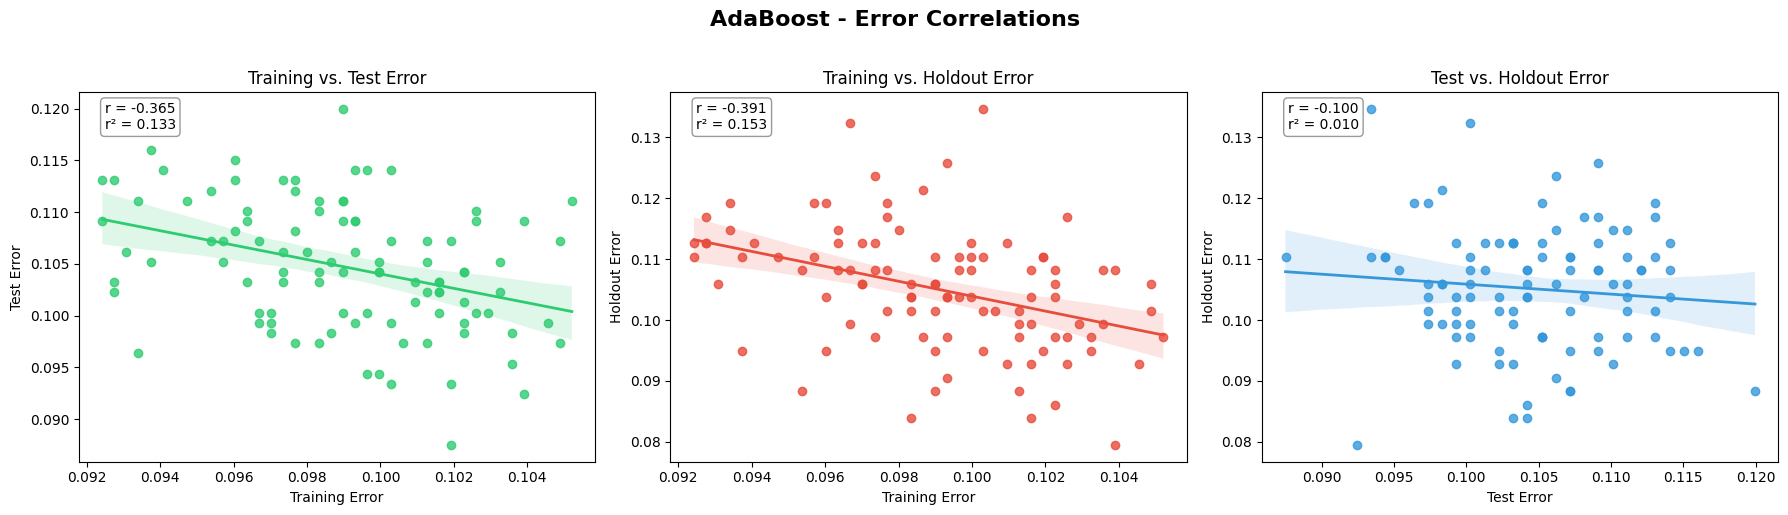


AdaBoost - Correlation Summary:
  Training vs Test:    r = -0.365, r² = 0.133, p = 1.891e-04
  Training vs Holdout: r = -0.391, r² = 0.153, p = 5.884e-05
  Test vs Holdout:     r = -0.100, r² = 0.010, p = 3.245e-01


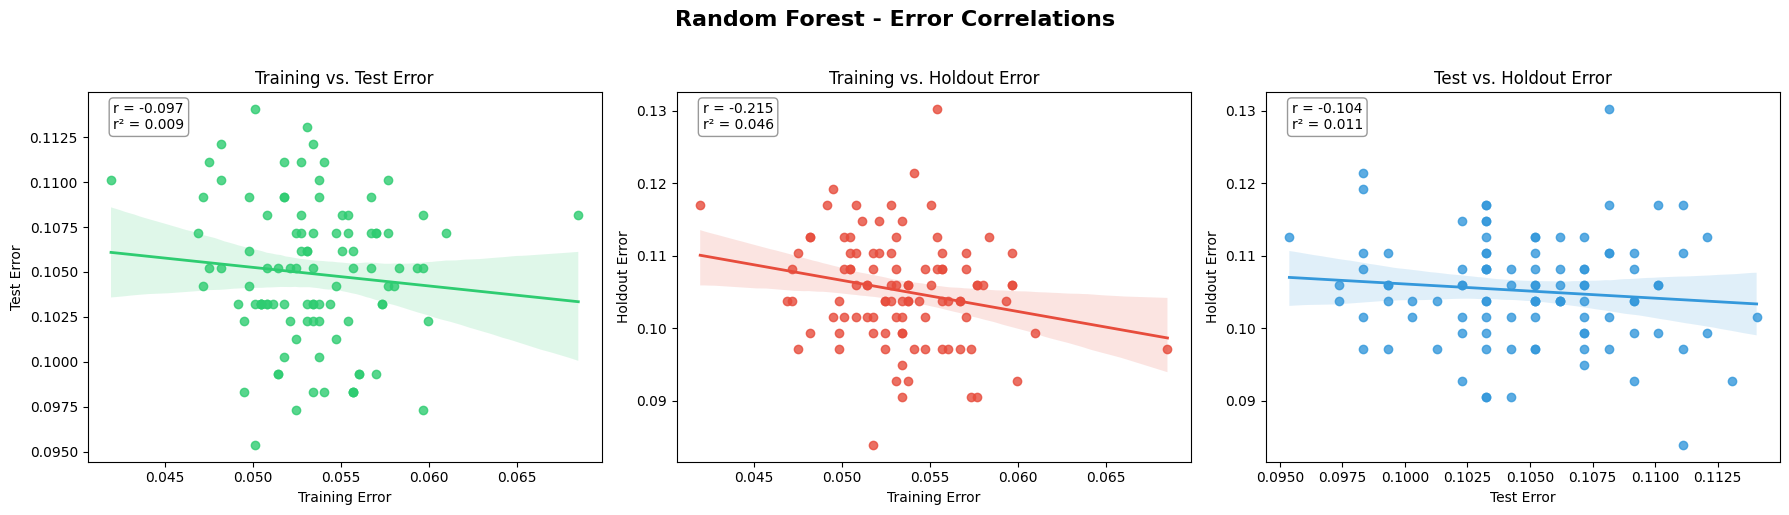


Random Forest - Correlation Summary:
  Training vs Test:    r = -0.097, r² = 0.009, p = 3.350e-01
  Training vs Holdout: r = -0.215, r² = 0.046, p = 3.194e-02
  Test vs Holdout:     r = -0.104, r² = 0.011, p = 3.039e-01


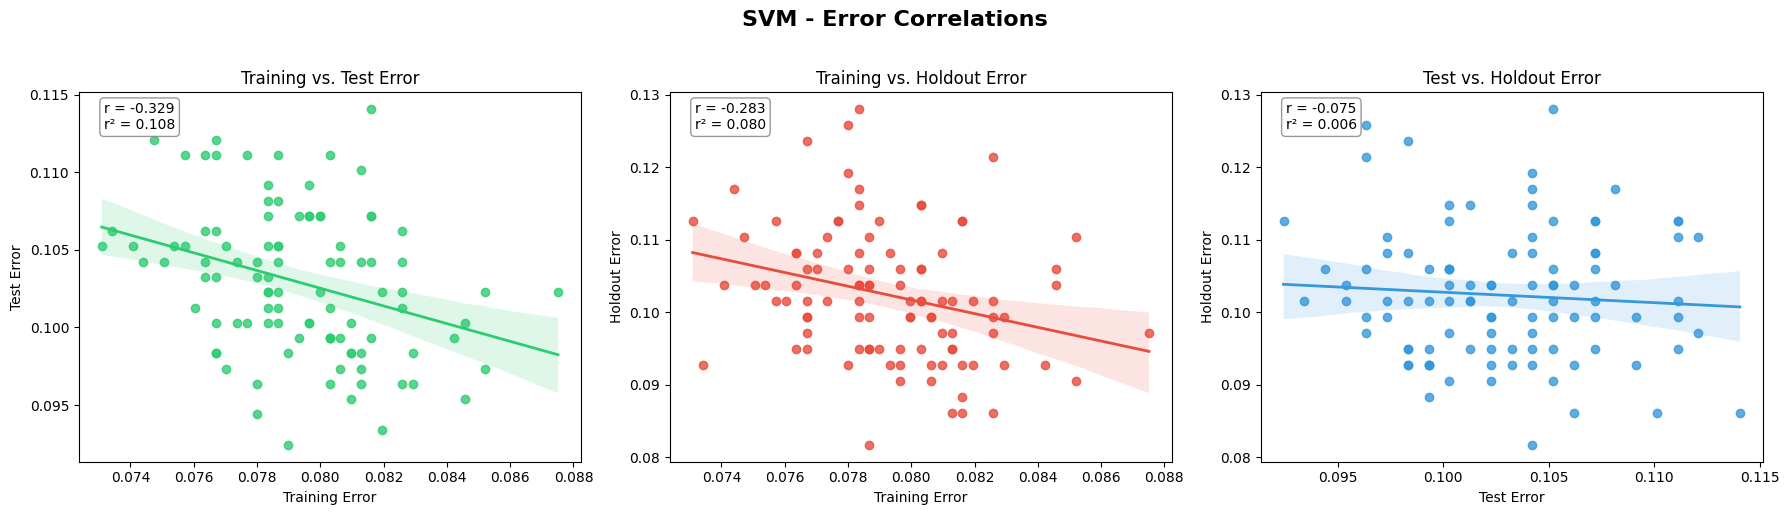


SVM - Correlation Summary:
  Training vs Test:    r = -0.329, r² = 0.108, p = 8.391e-04
  Training vs Holdout: r = -0.283, r² = 0.080, p = 4.297e-03
  Test vs Holdout:     r = -0.075, r² = 0.006, p = 4.587e-01


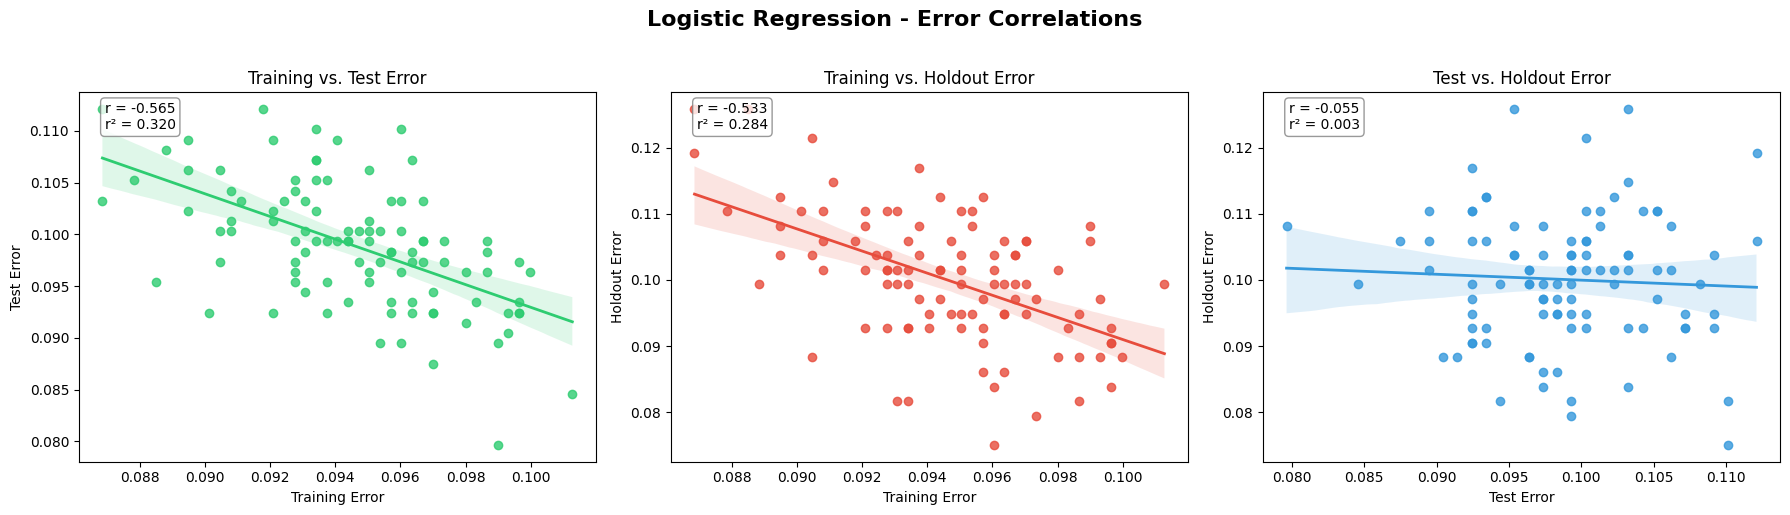


Logistic Regression - Correlation Summary:
  Training vs Test:    r = -0.565, r² = 0.320, p = 8.827e-10
  Training vs Holdout: r = -0.533, r² = 0.284, p = 1.150e-08
  Test vs Holdout:     r = -0.055, r² = 0.003, p = 5.855e-01


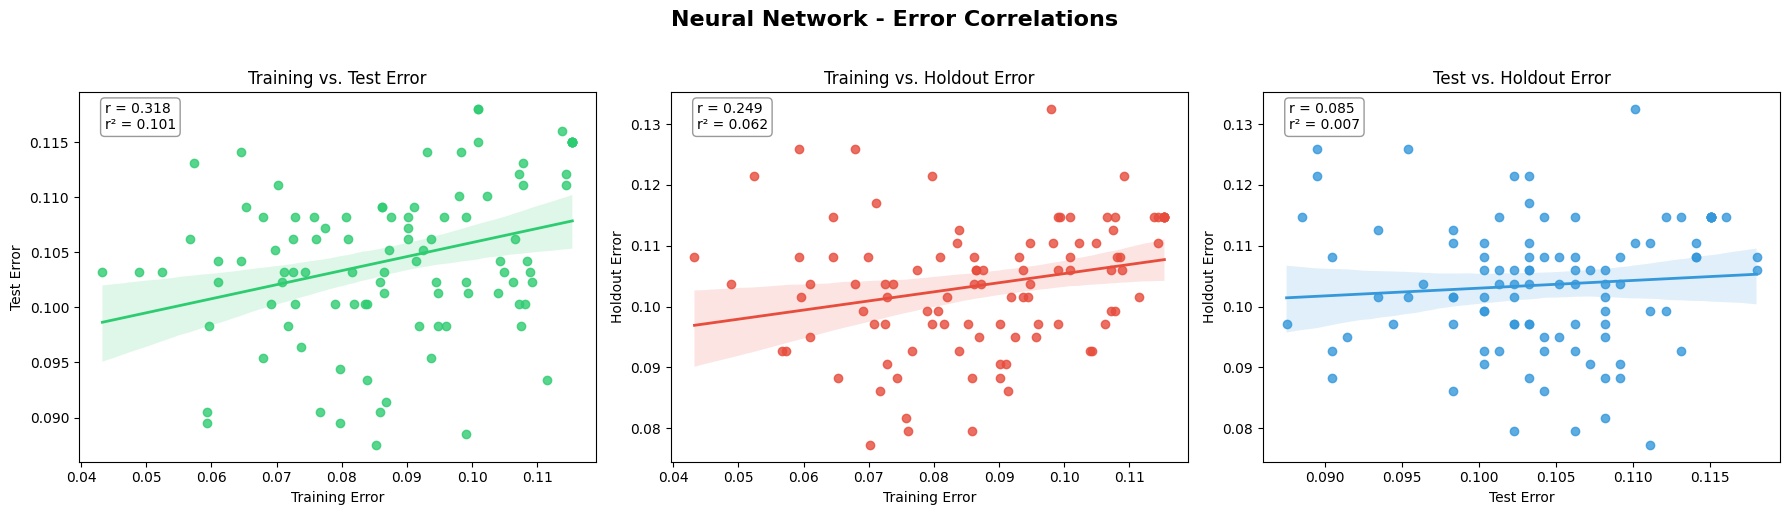


Neural Network - Correlation Summary:
  Training vs Test:    r = 0.318, r² = 0.101, p = 1.266e-03
  Training vs Holdout: r = 0.249, r² = 0.062, p = 1.251e-02
  Test vs Holdout:     r = 0.085, r² = 0.007, p = 4.017e-01

Creating correlation analysis...

CORRELATION SUMMARY TABLE
          Algorithm  Train-Test r  Train-Test r²  Train-Test p  Train-Holdout r  Train-Holdout r²  Train-Holdout p  Test-Holdout r  Test-Holdout r²  Test-Holdout p
           AdaBoost       -0.3649         0.1332        0.0002          -0.3906            0.1525           0.0001         -0.0995           0.0099          0.3245
      Random Forest       -0.0974         0.0095        0.3350          -0.2147            0.0461           0.0319         -0.1038           0.0108          0.3039
                SVM       -0.3288         0.1081        0.0008          -0.2832            0.0802           0.0043         -0.0749           0.0056          0.4587
Logistic Regression       -0.5654         0.3197        0.0000  

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

def create_algorithm_specific_plots(results_df):
    """
    Create separate error comparison plots for each algorithm, mimicking the provided style

    Parameters:
    results_df: DataFrame with columns ['Algorithm', 'Training Error', 'Test Error', 'Holdout Error']
    """
    # Define custom colors (same as the original)
    custom_colors = ["#2ecc71",  # Green
                     "#e74c3c",  # Red
                     "#3498db",  # Blue
                     "#9b59b6"]  # Purple

    # Get unique algorithms
    algorithms = results_df['Algorithm'].unique()

    # Create plots for each algorithm
    for i, algorithm in enumerate(algorithms):
        # Filter data for current algorithm
        algo_df = results_df[results_df['Algorithm'] == algorithm].copy()

        # Set figure size for a row of 3 plots
        plt.figure(figsize=(18, 5))

        # Set the color palette
        sns.set_palette(custom_colors)

        # First plot: Training vs Test Error
        plt.subplot(1, 3, 1)
        # Calculate correlation coefficient (R) and p-value
        r_train_test, p_train_test = stats.pearsonr(algo_df['Training Error'], algo_df['Test Error'])
        r2_train_test = r_train_test**2
        # Add regression plot
        sns.regplot(data=algo_df, x='Training Error', y='Test Error',
                    scatter_kws={'color': custom_colors[0]},
                    line_kws={'color': custom_colors[0], 'linewidth': 2})
        # Add R and R² text
        plt.annotate(f'r = {r_train_test:.3f}\nr² = {r2_train_test:.3f}',
                     xy=(0.05, 0.90), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        plt.title('Training vs. Test Error')
        plt.xlabel('Training Error')
        plt.ylabel('Test Error')

        # Second plot: Training vs Holdout Error
        plt.subplot(1, 3, 2)
        # Calculate correlation coefficient (R) and p-value
        r_train_holdout, p_train_holdout = stats.pearsonr(algo_df['Training Error'], algo_df['Holdout Error'])
        r2_train_holdout = r_train_holdout**2
        # Add regression plot
        sns.regplot(data=algo_df, x='Training Error', y='Holdout Error',
                    scatter_kws={'color': custom_colors[1]},
                    line_kws={'color': custom_colors[1], 'linewidth': 2})
        # Add R and R² text
        plt.annotate(f'r = {r_train_holdout:.3f}\nr² = {r2_train_holdout:.3f}',
                     xy=(0.05, 0.90), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        plt.title('Training vs. Holdout Error')
        plt.xlabel('Training Error')
        plt.ylabel('Holdout Error')

        # Third plot: Test vs Holdout Error
        plt.subplot(1, 3, 3)
        # Calculate correlation coefficient (R) and p-value
        r_test_holdout, p_test_holdout = stats.pearsonr(algo_df['Test Error'], algo_df['Holdout Error'])
        r2_test_holdout = r_test_holdout**2
        # Add regression plot
        sns.regplot(data=algo_df, x='Test Error', y='Holdout Error',
                    scatter_kws={'color': custom_colors[2]},
                    line_kws={'color': custom_colors[2], 'linewidth': 2})
        # Add R and R² text
        plt.annotate(f'r = {r_test_holdout:.3f}\nr² = {r2_test_holdout:.3f}',
                     xy=(0.05, 0.90), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        plt.title('Test vs. Holdout Error')
        plt.xlabel('Test Error')
        plt.ylabel('Holdout Error')

        # Add main title for the algorithm
        plt.suptitle(f'{algorithm} - Error Correlations', fontsize=16, fontweight='bold', y=1.02)

        # Adjust layout to prevent overlap
        plt.tight_layout()

        # Save individual plots
        plt.savefig(f'{algorithm.replace(" ", "_")}_error_correlations.png',
                   dpi=300, bbox_inches='tight')

        # Show the plots
        plt.show()

        # Print correlation summary for this algorithm
        print(f"\n{algorithm} - Correlation Summary:")
        print(f"  Training vs Test:    r = {r_train_test:.3f}, r² = {r2_train_test:.3f}, p = {p_train_test:.3e}")
        print(f"  Training vs Holdout: r = {r_train_holdout:.3f}, r² = {r2_train_holdout:.3f}, p = {p_train_holdout:.3e}")
        print(f"  Test vs Holdout:     r = {r_test_holdout:.3f}, r² = {r2_test_holdout:.3f}, p = {p_test_holdout:.3e}")

def create_summary_correlation_table(results_df):
    """
    Create a summary table of all correlations across algorithms
    """
    algorithms = results_df['Algorithm'].unique()
    correlation_summary = []

    for algorithm in algorithms:
        algo_df = results_df[results_df['Algorithm'] == algorithm].copy()

        # Calculate correlations
        r_train_test, p_train_test = stats.pearsonr(algo_df['Training Error'], algo_df['Test Error'])
        r_train_holdout, p_train_holdout = stats.pearsonr(algo_df['Training Error'], algo_df['Holdout Error'])
        r_test_holdout, p_test_holdout = stats.pearsonr(algo_df['Test Error'], algo_df['Holdout Error'])

        correlation_summary.append({
            'Algorithm': algorithm,
            'Train-Test r': r_train_test,
            'Train-Test r²': r_train_test**2,
            'Train-Test p': p_train_test,
            'Train-Holdout r': r_train_holdout,
            'Train-Holdout r²': r_train_holdout**2,
            'Train-Holdout p': p_train_holdout,
            'Test-Holdout r': r_test_holdout,
            'Test-Holdout r²': r_test_holdout**2,
            'Test-Holdout p': p_test_holdout
        })

    correlation_df = pd.DataFrame(correlation_summary)

    print("\n" + "="*80)
    print("CORRELATION SUMMARY TABLE")
    print("="*80)
    print(correlation_df.round(4).to_string(index=False))

    return correlation_df

def analyze_correlation_patterns(results_df):
    """
    Analyze patterns in correlations across algorithms
    """
    correlation_df = create_summary_correlation_table(results_df)

    print("\n" + "="*60)
    print("CORRELATION ANALYSIS")
    print("="*60)

    # Find algorithm with highest/lowest correlations
    print(f"\nHighest Train-Test correlation: {correlation_df.loc[correlation_df['Train-Test r'].idxmax(), 'Algorithm']} "
          f"(r = {correlation_df['Train-Test r'].max():.3f})")
    print(f"Lowest Train-Test correlation:  {correlation_df.loc[correlation_df['Train-Test r'].idxmin(), 'Algorithm']} "
          f"(r = {correlation_df['Train-Test r'].min():.3f})")

    print(f"\nHighest Train-Holdout correlation: {correlation_df.loc[correlation_df['Train-Holdout r'].idxmax(), 'Algorithm']} "
          f"(r = {correlation_df['Train-Holdout r'].max():.3f})")
    print(f"Lowest Train-Holdout correlation:  {correlation_df.loc[correlation_df['Train-Holdout r'].idxmin(), 'Algorithm']} "
          f"(r = {correlation_df['Train-Holdout r'].min():.3f})")

    print(f"\nHighest Test-Holdout correlation: {correlation_df.loc[correlation_df['Test-Holdout r'].idxmax(), 'Algorithm']} "
          f"(r = {correlation_df['Test-Holdout r'].max():.3f})")
    print(f"Lowest Test-Holdout correlation:  {correlation_df.loc[correlation_df['Test-Holdout r'].idxmin(), 'Algorithm']} "
          f"(r = {correlation_df['Test-Holdout r'].min():.3f})")

    # Interpretation guide
    print(f"\n" + "="*60)
    print("INTERPRETATION GUIDE")
    print("="*60)
    print("• High Train-Test correlation suggests consistent overfitting patterns")
    print("• Low Train-Holdout correlation may indicate unstable generalization")
    print("• High Test-Holdout correlation suggests good validation set reliability")
    print("• r² values show proportion of variance explained by the relationship")

    return correlation_df

# Example usage and main execution
if __name__ == "__main__":
    # Try to load results from CSV
    try:
        results_df = bank_df
        print("Loaded results from CSV file")
        print(f"Found {len(results_df)} results for {len(results_df['Algorithm'].unique())} algorithms")

        # Create algorithm-specific plots
        print("\nCreating algorithm-specific error correlation plots...")
        create_algorithm_specific_plots(results_df)

        # Create summary analysis
        print("\nCreating correlation analysis...")
        correlation_summary = analyze_correlation_patterns(results_df)

    except FileNotFoundError:
        print("No results file found. Please run the main experiment first.")
        print("Expected file: 'multi_algorithm_results.csv'")

        # Create sample data for demonstration
        print("\nCreating sample visualization with dummy data...")
        np.random.seed(42)
        algorithms = ['AdaBoost', 'Random Forest', 'SVM', 'Logistic Regression', 'Neural Network']
        sample_data = []

        for algo in algorithms:
            # Create different correlation patterns for each algorithm
            base_error = np.random.uniform(0.15, 0.25)

            for seed in range(50):  # More points for better correlation analysis
                if algo == 'AdaBoost':
                    # High correlation between train and test
                    train_err = np.random.uniform(0.1, 0.2)
                    test_err = train_err + np.random.normal(0.05, 0.02)
                    holdout_err = train_err + np.random.normal(0.06, 0.025)
                elif algo == 'Random Forest':
                    # Lower training error, moderate correlation
                    train_err = np.random.uniform(0.05, 0.15)
                    test_err = train_err + np.random.normal(0.08, 0.03)
                    holdout_err = test_err + np.random.normal(0.01, 0.02)
                elif algo == 'SVM':
                    # More consistent across all error types
                    base = np.random.uniform(0.15, 0.25)
                    train_err = base + np.random.normal(0, 0.01)
                    test_err = base + np.random.normal(0.02, 0.015)
                    holdout_err = base + np.random.normal(0.025, 0.02)
                elif algo == 'Logistic Regression':
                    # Linear relationship between errors
                    train_err = np.random.uniform(0.12, 0.22)
                    test_err = train_err * 1.1 + np.random.normal(0.01, 0.01)
                    holdout_err = train_err * 1.12 + np.random.normal(0.015, 0.015)
                else:  # Neural Network
                    # More variable, some overfitting
                    train_err = np.random.uniform(0.08, 0.18)
                    test_err = train_err + np.random.exponential(0.05)
                    holdout_err = train_err + np.random.exponential(0.06)

                # Ensure errors are positive and reasonable
                train_err = max(0.01, min(0.5, train_err))
                test_err = max(0.01, min(0.5, test_err))
                holdout_err = max(0.01, min(0.5, holdout_err))

                sample_data.append({
                    'Algorithm': algo,
                    'Seed': seed,
                    'Training Error': train_err,
                    'Test Error': test_err,
                    'Holdout Error': holdout_err
                })

        #sample_df = pd.DataFrame(sample_data)
        #print("Created sample data with realistic correlation patterns")

        # Create the visualizations with sample data
        create_algorithm_specific_plots(bank_df)
        analyze_correlation_patterns(bank_df)

##Interpretation of Results (UCI Bank Marketing)

Here we again see anti-correlation in both Training vs. Test Error and Training vs. Holdout Error plots, for all models except NN with similiar values of both $r$ and $r^2$. This is most likely to do with some hidden effects in $p_{\rm train}(\delta) = \mu - \alpha\,\delta$.

# Repeated Trials with Synthetic Data

#### We then wanted to control the conditions and see if we could assess model impacts more directly, below we created data with a linear boundary off of one feature and a more complex linear boundary with multiple features creating the boundary. We also randomly flip 30% of the targets to introduce noise. We then ran the same AdaBoost CV procedure as before.

## Analysis of Simple Synthetic Data

#### Data was generated with 10 total features and 1000 instances, where one feature determined the target binary classification. We randomly selected 30% of target value bits to be flipped to introduce noise.

In [ ]:
def generate_linear_data(noise_level=0.3, random_state=None):
    rng = np.random.RandomState(random_state)
    X = rng.rand(1000, 10)  # 1000 samples, 10 features

    # Linear relationship with first feature
    y = (X[:, 0] > 0.5).astype(int)

    # Add noise
    if noise_level > 0:
        flip_indices = rng.choice(1000, size=int(1000 * noise_level), replace=False)
        y[flip_indices] = 1 - y[flip_indices]

    # Convert X to DataFrame
    X_df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])

    return X_df, y

# Define your base learner (decision stump is common with AdaBoost)
base_learner = DecisionTreeClassifier(max_depth=1)

n_runs = 100
# Initialize result list
results_linear = []

X, y = generate_linear_data(noise_level=0.3, random_state=99)

# Define all algorithms to test
def get_algorithms():
    """
    Define the algorithms to compare
    """
    base_learner = DecisionTreeClassifier(max_depth=1)

    algorithms = {
        'AdaBoost': AdaBoostClassifier(
            estimator=base_learner,
            n_estimators=50,
            random_state=42
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42
        ),
        'SVM': SVC(
            kernel='rbf',
            C=1.0,
            random_state=42
        ),
        'Logistic Regression': LogisticRegression(
            max_iter=1000,
            random_state=42
        ),
        'Neural Network': MLPClassifier(
            hidden_layer_sizes=(100, 50),
            max_iter=300,
            random_state=42,
            early_stopping=True,
            validation_fraction=0.1
        )
    }

    return algorithms

# Run cross-validation experiment for all algorithms
def run_multi_algorithm_experiment(X, y,  n_runs=100):
    """
    Run the experiment with multiple algorithms using the same CV setup
    """
    algorithms = get_algorithms()
    results = []

    # Identify numeric and categorical columns (assuming all are numeric for synthetic data)
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    # Define preprocessing for numerical and categorical features
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    # Create preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])


    for seed in range(n_runs):
        # Split into train-val and holdout sets
        X_train_val, X_holdout, y_train_val, y_holdout = train_test_split(
            X, y, test_size=0.1, random_state=seed, stratify=y)

        # Further split train-val into train and test
        X_train, X_test, y_train, y_test = train_test_split(
            X_train_val, y_train_val, test_size=0.25, random_state=seed, stratify=y_train_val)

        # Test each algorithm
        for algo_name, algorithm in algorithms.items():
            # Create pipeline with the current algorithm
            # Note: We need to create a fresh copy of the algorithm for each run
            if algo_name == 'AdaBoost':
                base_learner = DecisionTreeClassifier(max_depth=1)
                current_algo = AdaBoostClassifier(
                    estimator=base_learner,
                    n_estimators=50,
                    random_state=seed
                )
            elif algo_name == 'Random Forest':
                current_algo = RandomForestClassifier(
                    n_estimators=100,
                    max_depth=10,
                    random_state=seed
                )
            elif algo_name == 'SVM':
                current_algo = SVC(
                    kernel='rbf',
                    C=1.0,
                    random_state=seed
                )
            elif algo_name == 'Logistic Regression':
                current_algo = LogisticRegression(
                    max_iter=1000,
                    random_state=seed
                )
            elif algo_name == 'Neural Network':
                current_algo = MLPClassifier(
                    hidden_layer_sizes=(100, 50),
                    max_iter=300,
                    random_state=seed,
                    early_stopping=True,
                    validation_fraction=0.1
                )

            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', current_algo)
            ])

            # Train the pipeline
            pipeline.fit(X_train, y_train)

            # Calculate errors
            train_error = 1 - accuracy_score(y_train, pipeline.predict(X_train))
            test_error = 1 - accuracy_score(y_test, pipeline.predict(X_test))
            holdout_error = 1 - accuracy_score(y_holdout, pipeline.predict(X_holdout))

            results.append({
                'Algorithm': algo_name,
                'Seed': seed,
                'Training Error': train_error,
                'Test Error': test_error,
                'Holdout Error': holdout_error
            })

        # Print progress every 10 runs
        if (seed + 1) % 10 == 0:
            print(f"Completed {seed + 1}/{n_runs} runs")

    return pd.DataFrame(results)



# Main execution
if __name__ == "__main__":

    print("\nStarting multi-algorithm experiment...")
    print("This may take several minutes...")

    # Run the experiment with fewer runs for demonstration
    # Change n_runs to 100 for full experiment
    linear_df = run_multi_algorithm_experiment(X, y, n_runs=100)


Starting multi-algorithm experiment...
This may take several minutes...
Completed 10/100 runs
Completed 20/100 runs
Completed 30/100 runs
Completed 40/100 runs
Completed 50/100 runs
Completed 60/100 runs
Completed 70/100 runs
Completed 80/100 runs
Completed 90/100 runs
Completed 100/100 runs


Loaded results from CSV file
Found 500 results for 5 algorithms

Creating algorithm-specific error correlation plots...


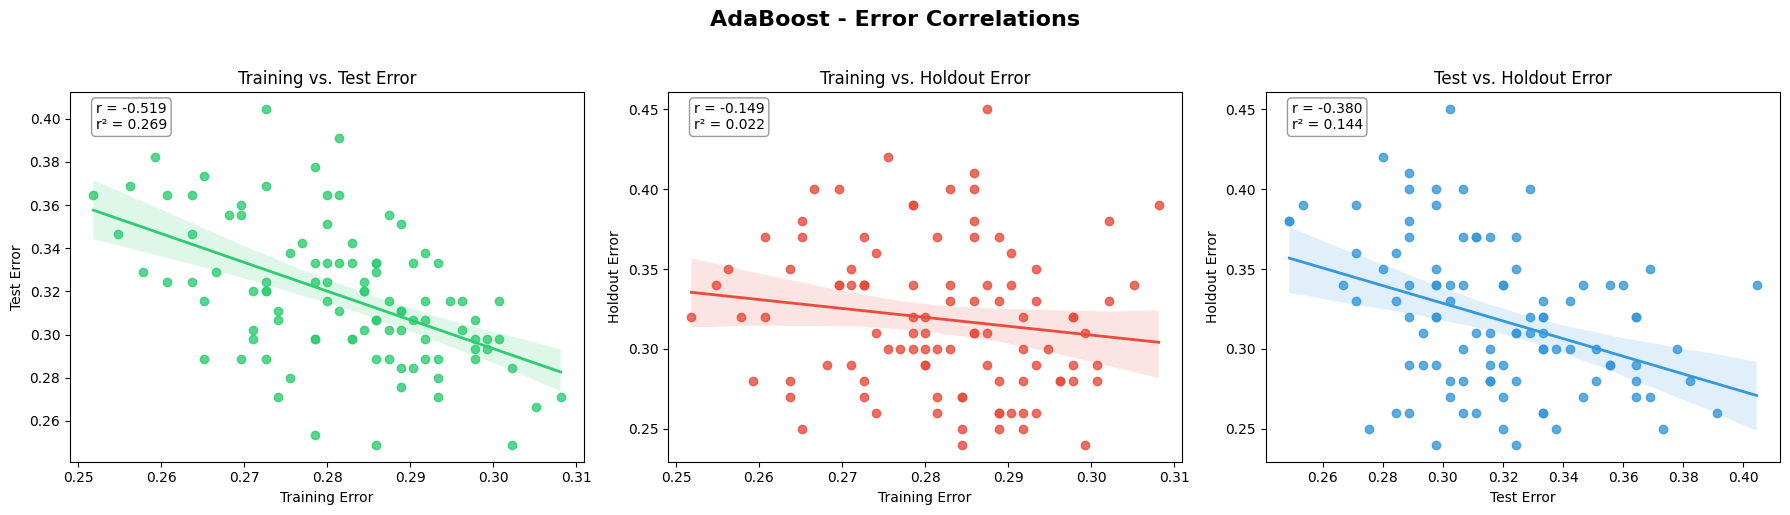


AdaBoost - Correlation Summary:
  Training vs Test:    r = -0.519, r² = 0.269, p = 3.205e-08
  Training vs Holdout: r = -0.149, r² = 0.022, p = 1.398e-01
  Test vs Holdout:     r = -0.380, r² = 0.144, p = 9.691e-05


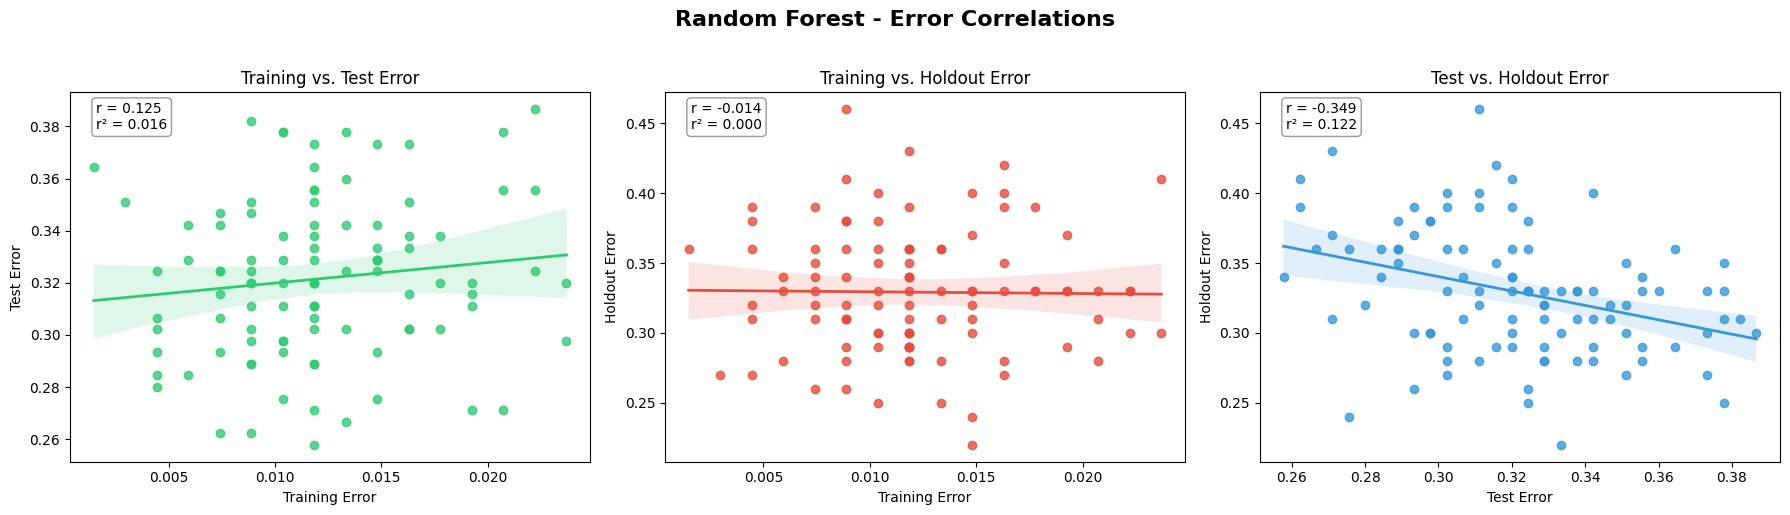


Random Forest - Correlation Summary:
  Training vs Test:    r = 0.125, r² = 0.016, p = 2.145e-01
  Training vs Holdout: r = -0.014, r² = 0.000, p = 8.932e-01
  Test vs Holdout:     r = -0.349, r² = 0.122, p = 3.716e-04


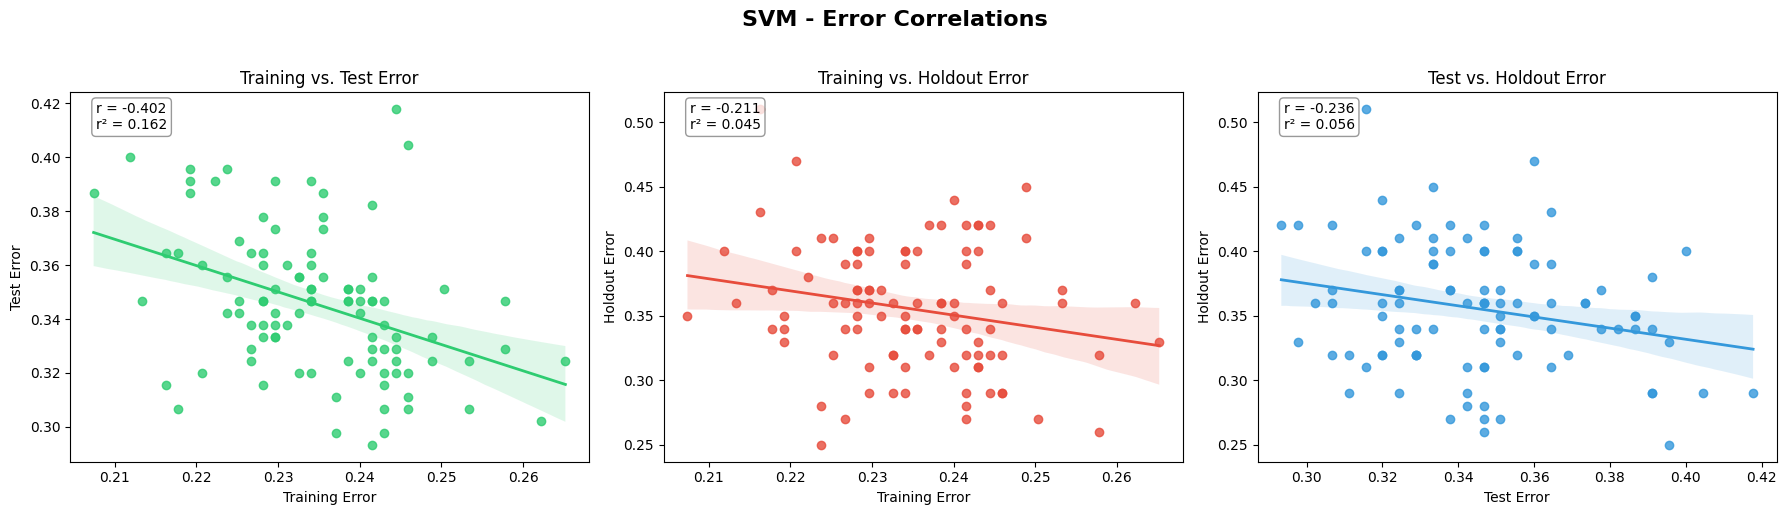


SVM - Correlation Summary:
  Training vs Test:    r = -0.402, r² = 0.162, p = 3.404e-05
  Training vs Holdout: r = -0.211, r² = 0.045, p = 3.480e-02
  Test vs Holdout:     r = -0.236, r² = 0.056, p = 1.823e-02


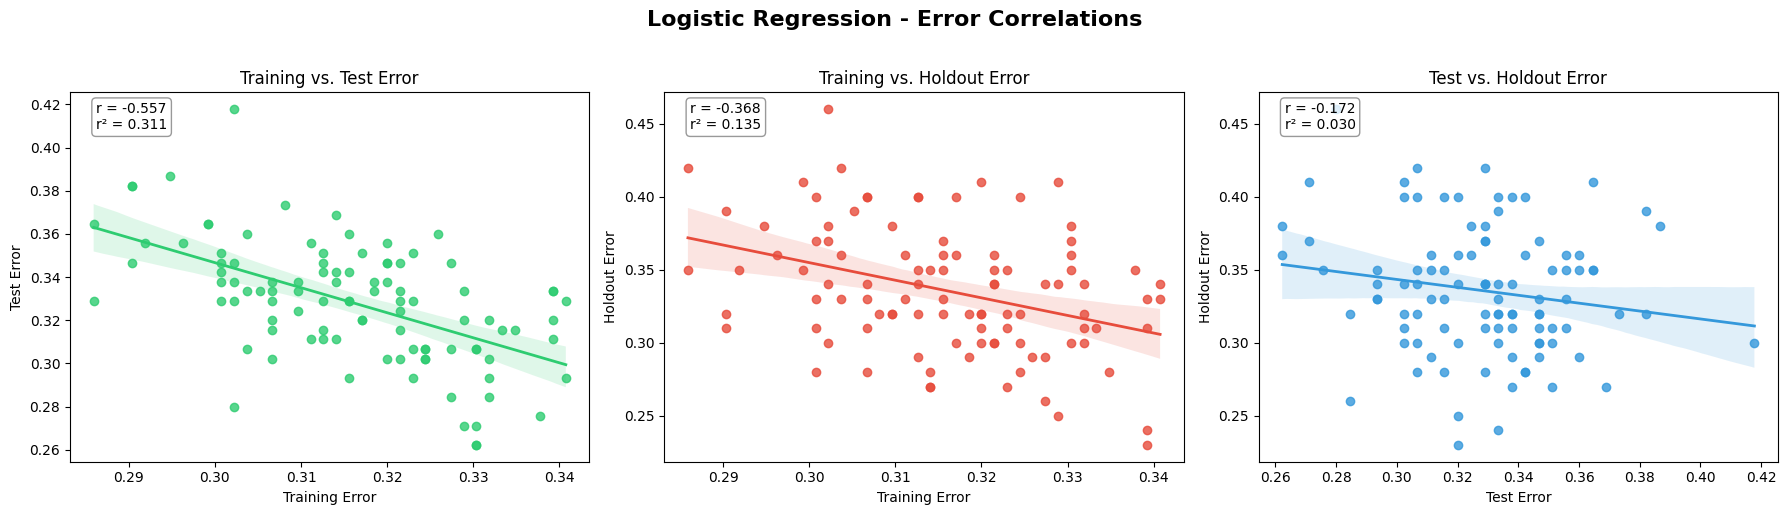


Logistic Regression - Correlation Summary:
  Training vs Test:    r = -0.557, r² = 0.311, p = 1.698e-09
  Training vs Holdout: r = -0.368, r² = 0.135, p = 1.656e-04
  Test vs Holdout:     r = -0.172, r² = 0.030, p = 8.748e-02


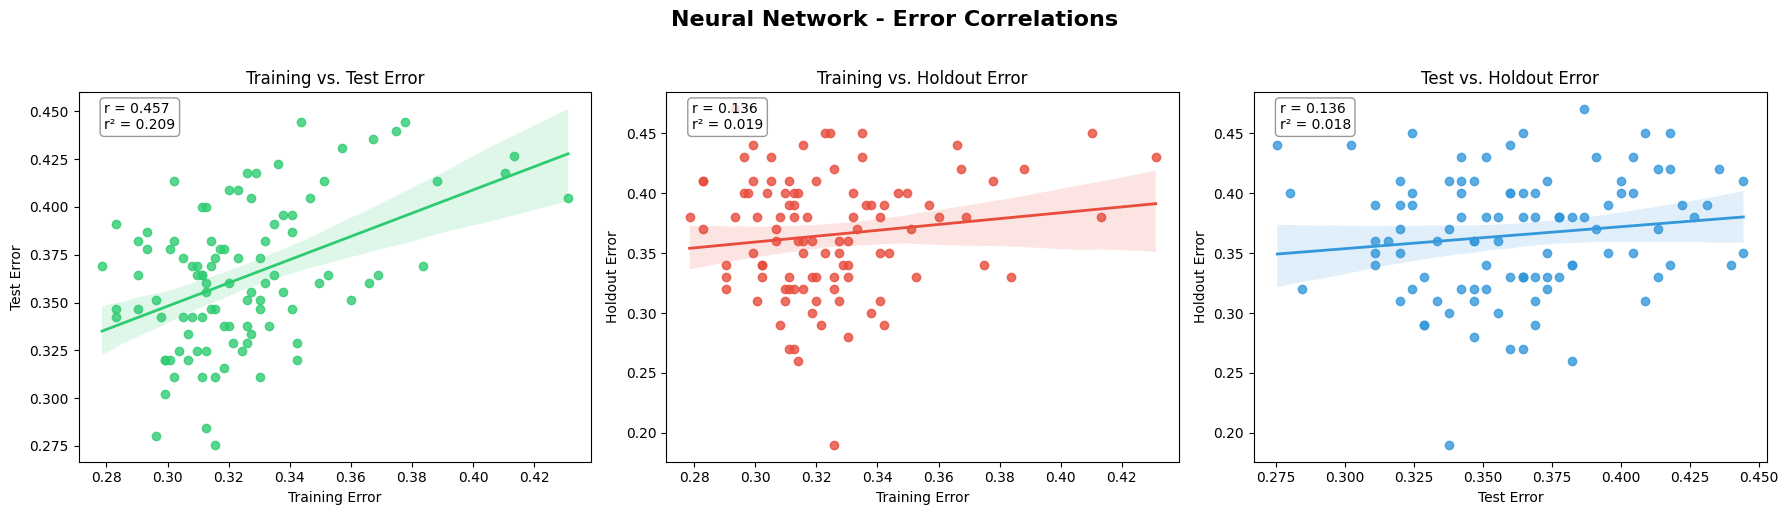


Neural Network - Correlation Summary:
  Training vs Test:    r = 0.457, r² = 0.209, p = 1.784e-06
  Training vs Holdout: r = 0.136, r² = 0.019, p = 1.766e-01
  Test vs Holdout:     r = 0.136, r² = 0.018, p = 1.773e-01

Creating correlation analysis...

CORRELATION SUMMARY TABLE
          Algorithm  Train-Test r  Train-Test r²  Train-Test p  Train-Holdout r  Train-Holdout r²  Train-Holdout p  Test-Holdout r  Test-Holdout r²  Test-Holdout p
           AdaBoost       -0.5188         0.2692        0.0000          -0.1487            0.0221           0.1398         -0.3799           0.1443          0.0001
      Random Forest        0.1252         0.0157        0.2145          -0.0136            0.0002           0.8932         -0.3491           0.1219          0.0004
                SVM       -0.4019         0.1615        0.0000          -0.2113            0.0447           0.0348         -0.2357           0.0556          0.0182
Logistic Regression       -0.5575         0.3108        0.0000  

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

def create_algorithm_specific_plots(results_df):
    """
    Create separate error comparison plots for each algorithm, mimicking the provided style

    Parameters:
    results_df: DataFrame with columns ['Algorithm', 'Training Error', 'Test Error', 'Holdout Error']
    """
    # Define custom colors (same as the original)
    custom_colors = ["#2ecc71",  # Green
                     "#e74c3c",  # Red
                     "#3498db",  # Blue
                     "#9b59b6"]  # Purple

    # Get unique algorithms
    algorithms = results_df['Algorithm'].unique()

    # Create plots for each algorithm
    for i, algorithm in enumerate(algorithms):
        # Filter data for current algorithm
        algo_df = results_df[results_df['Algorithm'] == algorithm].copy()

        # Set figure size for a row of 3 plots
        plt.figure(figsize=(18, 5))

        # Set the color palette
        sns.set_palette(custom_colors)

        # First plot: Training vs Test Error
        plt.subplot(1, 3, 1)
        # Calculate correlation coefficient (R) and p-value
        r_train_test, p_train_test = stats.pearsonr(algo_df['Training Error'], algo_df['Test Error'])
        r2_train_test = r_train_test**2
        # Add regression plot
        sns.regplot(data=algo_df, x='Training Error', y='Test Error',
                    scatter_kws={'color': custom_colors[0]},
                    line_kws={'color': custom_colors[0], 'linewidth': 2})
        # Add R and R² text
        plt.annotate(f'r = {r_train_test:.3f}\nr² = {r2_train_test:.3f}',
                     xy=(0.05, 0.90), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        plt.title('Training vs. Test Error')
        plt.xlabel('Training Error')
        plt.ylabel('Test Error')

        # Second plot: Training vs Holdout Error
        plt.subplot(1, 3, 2)
        # Calculate correlation coefficient (R) and p-value
        r_train_holdout, p_train_holdout = stats.pearsonr(algo_df['Training Error'], algo_df['Holdout Error'])
        r2_train_holdout = r_train_holdout**2
        # Add regression plot
        sns.regplot(data=algo_df, x='Training Error', y='Holdout Error',
                    scatter_kws={'color': custom_colors[1]},
                    line_kws={'color': custom_colors[1], 'linewidth': 2})
        # Add R and R² text
        plt.annotate(f'r = {r_train_holdout:.3f}\nr² = {r2_train_holdout:.3f}',
                     xy=(0.05, 0.90), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        plt.title('Training vs. Holdout Error')
        plt.xlabel('Training Error')
        plt.ylabel('Holdout Error')

        # Third plot: Test vs Holdout Error
        plt.subplot(1, 3, 3)
        # Calculate correlation coefficient (R) and p-value
        r_test_holdout, p_test_holdout = stats.pearsonr(algo_df['Test Error'], algo_df['Holdout Error'])
        r2_test_holdout = r_test_holdout**2
        # Add regression plot
        sns.regplot(data=algo_df, x='Test Error', y='Holdout Error',
                    scatter_kws={'color': custom_colors[2]},
                    line_kws={'color': custom_colors[2], 'linewidth': 2})
        # Add R and R² text
        plt.annotate(f'r = {r_test_holdout:.3f}\nr² = {r2_test_holdout:.3f}',
                     xy=(0.05, 0.90), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        plt.title('Test vs. Holdout Error')
        plt.xlabel('Test Error')
        plt.ylabel('Holdout Error')

        # Add main title for the algorithm
        plt.suptitle(f'{algorithm} - Error Correlations', fontsize=16, fontweight='bold', y=1.02)

        # Adjust layout to prevent overlap
        plt.tight_layout()

        # Save individual plots
        plt.savefig(f'{algorithm.replace(" ", "_")}_error_correlations.png',
                   dpi=300, bbox_inches='tight')

        # Show the plots
        plt.show()

        # Print correlation summary for this algorithm
        print(f"\n{algorithm} - Correlation Summary:")
        print(f"  Training vs Test:    r = {r_train_test:.3f}, r² = {r2_train_test:.3f}, p = {p_train_test:.3e}")
        print(f"  Training vs Holdout: r = {r_train_holdout:.3f}, r² = {r2_train_holdout:.3f}, p = {p_train_holdout:.3e}")
        print(f"  Test vs Holdout:     r = {r_test_holdout:.3f}, r² = {r2_test_holdout:.3f}, p = {p_test_holdout:.3e}")

def create_summary_correlation_table(results_df):
    """
    Create a summary table of all correlations across algorithms
    """
    algorithms = results_df['Algorithm'].unique()
    correlation_summary = []

    for algorithm in algorithms:
        algo_df = results_df[results_df['Algorithm'] == algorithm].copy()

        # Calculate correlations
        r_train_test, p_train_test = stats.pearsonr(algo_df['Training Error'], algo_df['Test Error'])
        r_train_holdout, p_train_holdout = stats.pearsonr(algo_df['Training Error'], algo_df['Holdout Error'])
        r_test_holdout, p_test_holdout = stats.pearsonr(algo_df['Test Error'], algo_df['Holdout Error'])

        correlation_summary.append({
            'Algorithm': algorithm,
            'Train-Test r': r_train_test,
            'Train-Test r²': r_train_test**2,
            'Train-Test p': p_train_test,
            'Train-Holdout r': r_train_holdout,
            'Train-Holdout r²': r_train_holdout**2,
            'Train-Holdout p': p_train_holdout,
            'Test-Holdout r': r_test_holdout,
            'Test-Holdout r²': r_test_holdout**2,
            'Test-Holdout p': p_test_holdout
        })

    correlation_df = pd.DataFrame(correlation_summary)

    print("\n" + "="*80)
    print("CORRELATION SUMMARY TABLE")
    print("="*80)
    print(correlation_df.round(4).to_string(index=False))

    return correlation_df

def analyze_correlation_patterns(results_df):
    """
    Analyze patterns in correlations across algorithms
    """
    correlation_df = create_summary_correlation_table(results_df)

    print("\n" + "="*60)
    print("CORRELATION ANALYSIS")
    print("="*60)

    # Find algorithm with highest/lowest correlations
    print(f"\nHighest Train-Test correlation: {correlation_df.loc[correlation_df['Train-Test r'].idxmax(), 'Algorithm']} "
          f"(r = {correlation_df['Train-Test r'].max():.3f})")
    print(f"Lowest Train-Test correlation:  {correlation_df.loc[correlation_df['Train-Test r'].idxmin(), 'Algorithm']} "
          f"(r = {correlation_df['Train-Test r'].min():.3f})")

    print(f"\nHighest Train-Holdout correlation: {correlation_df.loc[correlation_df['Train-Holdout r'].idxmax(), 'Algorithm']} "
          f"(r = {correlation_df['Train-Holdout r'].max():.3f})")
    print(f"Lowest Train-Holdout correlation:  {correlation_df.loc[correlation_df['Train-Holdout r'].idxmin(), 'Algorithm']} "
          f"(r = {correlation_df['Train-Holdout r'].min():.3f})")

    print(f"\nHighest Test-Holdout correlation: {correlation_df.loc[correlation_df['Test-Holdout r'].idxmax(), 'Algorithm']} "
          f"(r = {correlation_df['Test-Holdout r'].max():.3f})")
    print(f"Lowest Test-Holdout correlation:  {correlation_df.loc[correlation_df['Test-Holdout r'].idxmin(), 'Algorithm']} "
          f"(r = {correlation_df['Test-Holdout r'].min():.3f})")

    # Interpretation guide
    print(f"\n" + "="*60)
    print("INTERPRETATION GUIDE")
    print("="*60)
    print("• High Train-Test correlation suggests consistent overfitting patterns")
    print("• Low Train-Holdout correlation may indicate unstable generalization")
    print("• High Test-Holdout correlation suggests good validation set reliability")
    print("• r² values show proportion of variance explained by the relationship")

    return correlation_df

# Example usage and main execution
if __name__ == "__main__":
    # Try to load results from CSV
    try:
        results_df = linear_df
        print("Loaded results from CSV file")
        print(f"Found {len(results_df)} results for {len(results_df['Algorithm'].unique())} algorithms")

        # Create algorithm-specific plots
        print("\nCreating algorithm-specific error correlation plots...")
        create_algorithm_specific_plots(results_df)

        # Create summary analysis
        print("\nCreating correlation analysis...")
        correlation_summary = analyze_correlation_patterns(results_df)

    except FileNotFoundError:
        print("No results file found. Please run the main experiment first.")
        print("Expected file: 'multi_algorithm_results.csv'")

        # Create sample data for demonstration
        print("\nCreating sample visualization with dummy data...")
        np.random.seed(42)
        algorithms = ['AdaBoost', 'Random Forest', 'SVM', 'Logistic Regression', 'Neural Network']
        sample_data = []

        for algo in algorithms:
            # Create different correlation patterns for each algorithm
            base_error = np.random.uniform(0.15, 0.25)

            for seed in range(50):  # More points for better correlation analysis
                if algo == 'AdaBoost':
                    # High correlation between train and test
                    train_err = np.random.uniform(0.1, 0.2)
                    test_err = train_err + np.random.normal(0.05, 0.02)
                    holdout_err = train_err + np.random.normal(0.06, 0.025)
                elif algo == 'Random Forest':
                    # Lower training error, moderate correlation
                    train_err = np.random.uniform(0.05, 0.15)
                    test_err = train_err + np.random.normal(0.08, 0.03)
                    holdout_err = test_err + np.random.normal(0.01, 0.02)
                elif algo == 'SVM':
                    # More consistent across all error types
                    base = np.random.uniform(0.15, 0.25)
                    train_err = base + np.random.normal(0, 0.01)
                    test_err = base + np.random.normal(0.02, 0.015)
                    holdout_err = base + np.random.normal(0.025, 0.02)
                elif algo == 'Logistic Regression':
                    # Linear relationship between errors
                    train_err = np.random.uniform(0.12, 0.22)
                    test_err = train_err * 1.1 + np.random.normal(0.01, 0.01)
                    holdout_err = train_err * 1.12 + np.random.normal(0.015, 0.015)
                else:  # Neural Network
                    # More variable, some overfitting
                    train_err = np.random.uniform(0.08, 0.18)
                    test_err = train_err + np.random.exponential(0.05)
                    holdout_err = train_err + np.random.exponential(0.06)

                # Ensure errors are positive and reasonable
                train_err = max(0.01, min(0.5, train_err))
                test_err = max(0.01, min(0.5, test_err))
                holdout_err = max(0.01, min(0.5, holdout_err))

                sample_data.append({
                    'Algorithm': algo,
                    'Seed': seed,
                    'Training Error': train_err,
                    'Test Error': test_err,
                    'Holdout Error': holdout_err
                })

        #sample_df = pd.DataFrame(sample_data)
        #print("Created sample data with realistic correlation patterns")

        # Create the visualizations with sample data
        create_algorithm_specific_plots(linear_df)
        analyze_correlation_patterns(linear_df)

## Interpretation of Results (Simple Synthetic)

#### Again we see the strong anti-correlation between Test and Train error, in this simple model however, we don't see any notable correlation in the other plots, suggesting less over-fitting in this model.

## Analysis of Complex Synthetic Data

#### Here we generated data and analyzed it in a similar way, this time just varying the amount of influential features in determining the target variable label, to create a more complex linearly seperable boundary.

In [ ]:
# Synthetic data generator
import numpy as np
from sklearn.utils import shuffle
import pandas as pd # Import pandas

def generate_linear_data(noise_level=0.3, random_state=None):
    rng = np.random.RandomState(random_state)
    X = rng.rand(1000, 10)  # Uniform [0, 1] features

    # Linearly combine several features
    weights = np.array([1.0,  1.0, .5])  # Example weights for features
    linear_combo = X[:, :3] @ weights     # Dot product: shape (1000,)

    # Decision boundary: label = 1 if linear combo > threshold
    y = (linear_combo > 0.5).astype(int)

    # Add label noise
    if noise_level > 0:
        flip_indices = rng.choice(len(y), size=int(len(y) * noise_level), replace=False)
        y[flip_indices] = 1 - y[flip_indices]

    # Convert X to DataFrame
    X_df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])

    return X_df, y
def generate_linear_data_simp(noise_level=0.3, random_state=None):
    rng = np.random.RandomState(random_state)
    X = rng.rand(1000, 10)  # 1000 samples, 10 features

    # Linear relationship with first feature
    y = (X[:, 0] > 0.5).astype(int)

    # Add noise
    if noise_level > 0:
        flip_indices = rng.choice(1000, size=int(1000 * noise_level), replace=False)
        y[flip_indices] = 1 - y[flip_indices]

    return X, y

from sklearn.tree import DecisionTreeClassifier
base_learner = DecisionTreeClassifier(max_depth=1)

results2 = []
# Generate data
X, y = generate_linear_data(noise_level=.3, random_state=99)
n_runs = 100


def get_algorithms():
    """
    Define the algorithms to compare
    """
    base_learner = DecisionTreeClassifier(max_depth=1)

    algorithms = {
        'AdaBoost': AdaBoostClassifier(
            estimator=base_learner,
            n_estimators=50,
            random_state=42
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42
        ),
        'SVM': SVC(
            kernel='rbf',
            C=1.0,
            random_state=42
        ),
        'Logistic Regression': LogisticRegression(
            max_iter=1000,
            random_state=42
        ),
        'Neural Network': MLPClassifier(
            hidden_layer_sizes=(100, 50),
            max_iter=300,
            random_state=42,
            early_stopping=True,
            validation_fraction=0.1
        )
    }

    return algorithms

# Run cross-validation experiment for all algorithms
def run_multi_algorithm_experiment(X, y,  n_runs=100):
    """
    Run the experiment with multiple algorithms using the same CV setup
    """
    algorithms = get_algorithms()
    results = []

    # Identify numeric and categorical columns (assuming all are numeric for synthetic data)
    # Ensure X is a DataFrame before using select_dtypes
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])

    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns


    # Define preprocessing for numerical and categorical features
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    # Create preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])


    for seed in range(n_runs):
        # Split into train-val and holdout sets
        X_train_val, X_holdout, y_train_val, y_holdout = train_test_split(
            X, y, test_size=0.1, random_state=seed, stratify=y)

        # Further split train-val into train and test
        X_train, X_test, y_train, y_test = train_test_split(
            X_train_val, y_train_val, test_size=0.25, random_state=seed, stratify=y_train_val)

        # Test each algorithm
        for algo_name, algorithm in algorithms.items():
            # Create pipeline with the current algorithm
            # Note: We need to create a fresh copy of the algorithm for each run
            if algo_name == 'AdaBoost':
                base_learner = DecisionTreeClassifier(max_depth=1)
                current_algo = AdaBoostClassifier(
                    estimator=base_learner,
                    n_estimators=50,
                    random_state=seed
                )
            elif algo_name == 'Random Forest':
                current_algo = RandomForestClassifier(
                    n_estimators=100,
                    max_depth=10,
                    random_state=seed
                )
            elif algo_name == 'SVM':
                current_algo = SVC(
                    kernel='rbf',
                    C=1.0,
                    random_state=seed
                )
            elif algo_name == 'Logistic Regression':
                current_algo = LogisticRegression(
                    max_iter=1000,
                    random_state=seed
                )
            elif algo_name == 'Neural Network':
                current_algo = MLPClassifier(
                    hidden_layer_sizes=(100, 50),
                    max_iter=300,
                    random_state=seed,
                    early_stopping=True,
                    validation_fraction=0.1
                )

            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('classifier', current_algo)
            ])

            # Train the pipeline
            pipeline.fit(X_train, y_train)

            # Calculate errors
            train_error = 1 - accuracy_score(y_train, pipeline.predict(X_train))
            test_error = 1 - accuracy_score(y_test, pipeline.predict(X_test))
            holdout_error = 1 - accuracy_score(y_holdout, pipeline.predict(X_holdout))

            results.append({
                'Algorithm': algo_name,
                'Seed': seed,
                'Training Error': train_error,
                'Test Error': test_error,
                'Holdout Error': holdout_error
            })

        # Print progress every 10 runs
        if (seed + 1) % 10 == 0:
            print(f"Completed {seed + 1}/{n_runs} runs")

    return pd.DataFrame(results)



# Main execution
if __name__ == "__main__":

    print("\nStarting multi-algorithm experiment...")
    print("This may take several minutes...")

    # Run the experiment with fewer runs for demonstration
    # Change n_runs to 100 for full experiment
    result_df = run_multi_algorithm_experiment(X, y, n_runs=100)


Starting multi-algorithm experiment...
This may take several minutes...
Completed 10/100 runs
Completed 20/100 runs
Completed 30/100 runs
Completed 40/100 runs
Completed 50/100 runs
Completed 60/100 runs
Completed 70/100 runs
Completed 80/100 runs
Completed 90/100 runs
Completed 100/100 runs


## Visualization of Synthetic Data with Multiple Signal Features

Loaded results from CSV file
Found 500 results for 5 algorithms

Creating algorithm-specific error correlation plots...


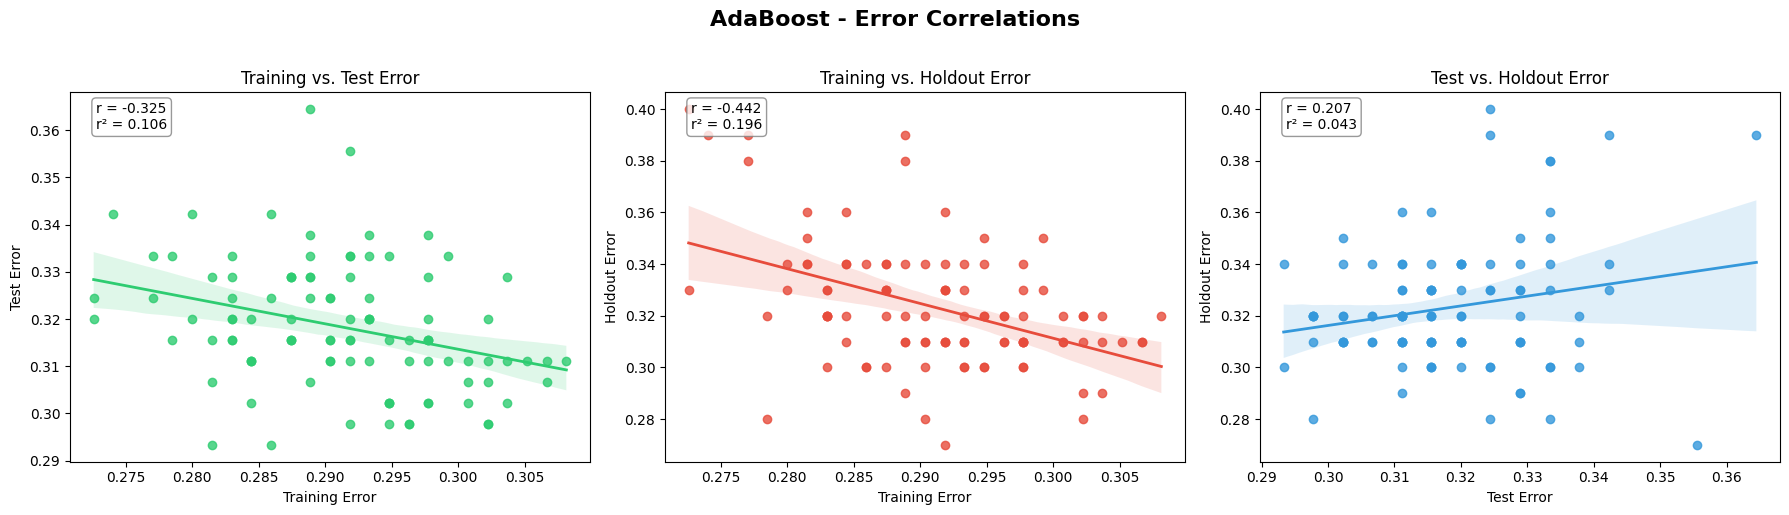


AdaBoost - Correlation Summary:
  Training vs Test:    r = -0.325, r² = 0.106, p = 9.767e-04
  Training vs Holdout: r = -0.442, r² = 0.196, p = 4.061e-06
  Test vs Holdout:     r = 0.207, r² = 0.043, p = 3.919e-02


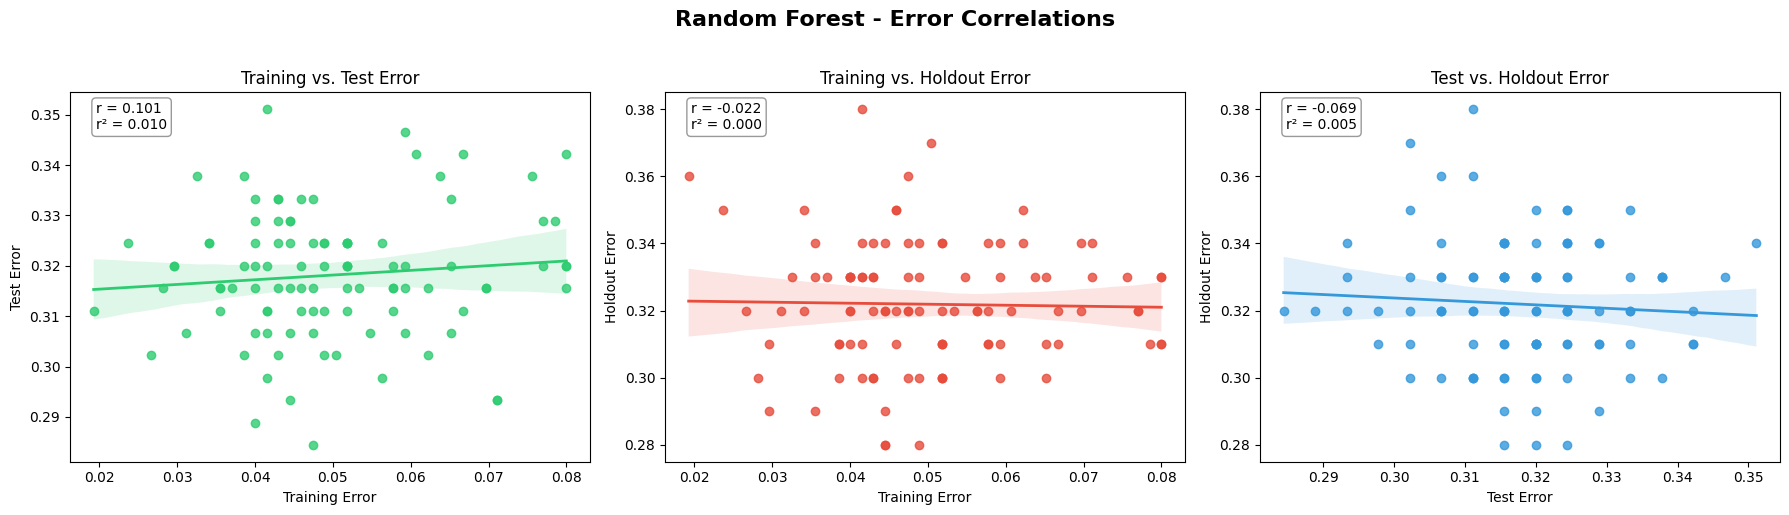


Random Forest - Correlation Summary:
  Training vs Test:    r = 0.101, r² = 0.010, p = 3.188e-01
  Training vs Holdout: r = -0.022, r² = 0.000, p = 8.293e-01
  Test vs Holdout:     r = -0.069, r² = 0.005, p = 4.961e-01


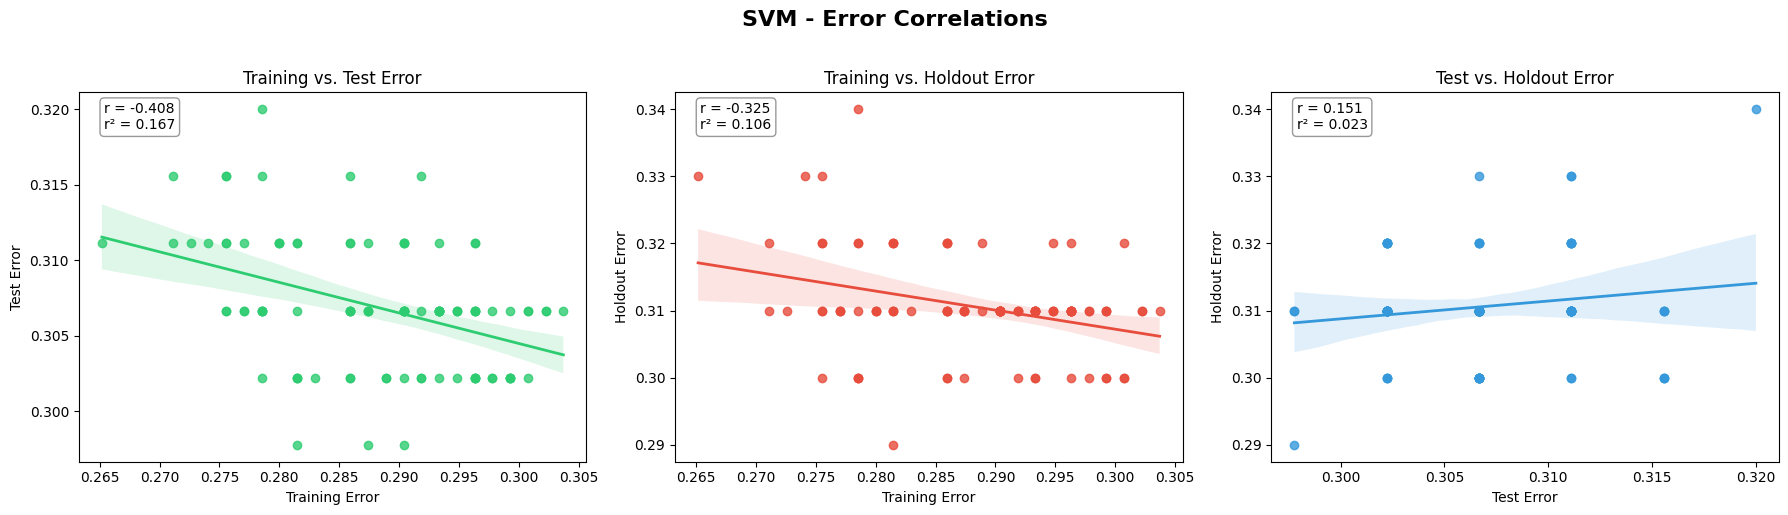


SVM - Correlation Summary:
  Training vs Test:    r = -0.408, r² = 0.167, p = 2.469e-05
  Training vs Holdout: r = -0.325, r² = 0.106, p = 9.639e-04
  Test vs Holdout:     r = 0.151, r² = 0.023, p = 1.348e-01


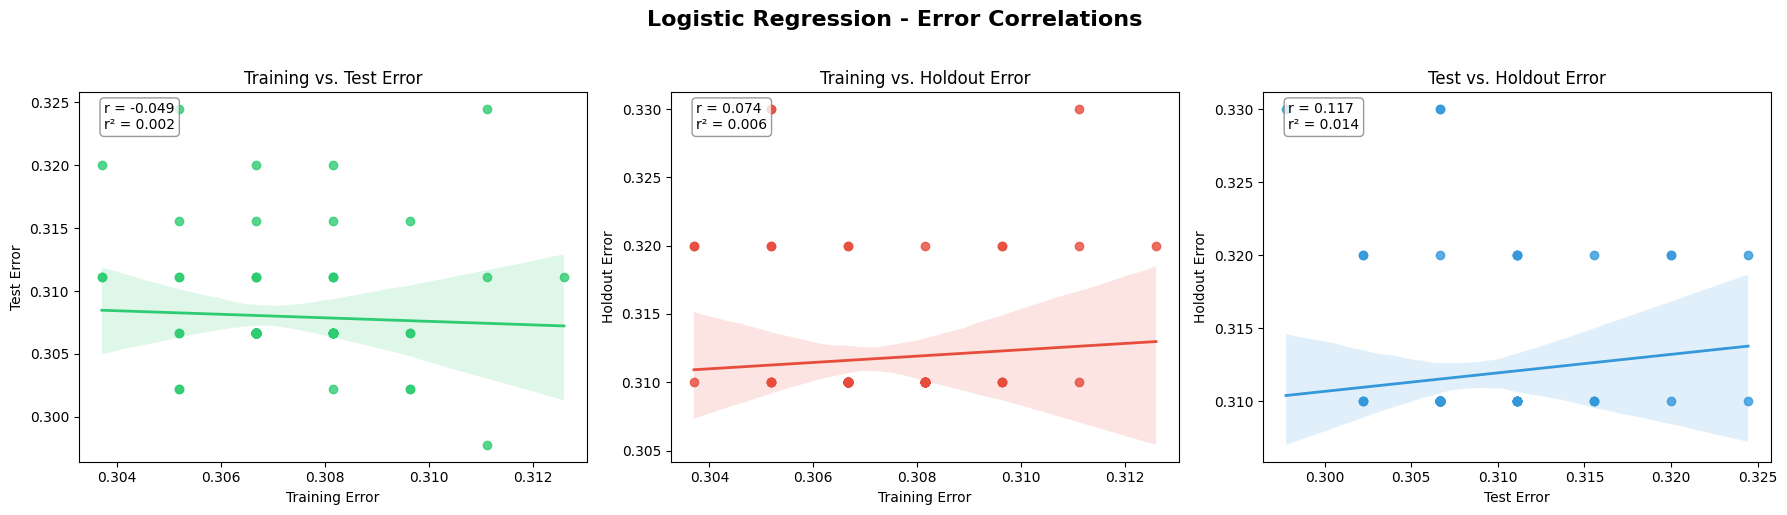


Logistic Regression - Correlation Summary:
  Training vs Test:    r = -0.049, r² = 0.002, p = 6.310e-01
  Training vs Holdout: r = 0.074, r² = 0.006, p = 4.616e-01
  Test vs Holdout:     r = 0.117, r² = 0.014, p = 2.457e-01


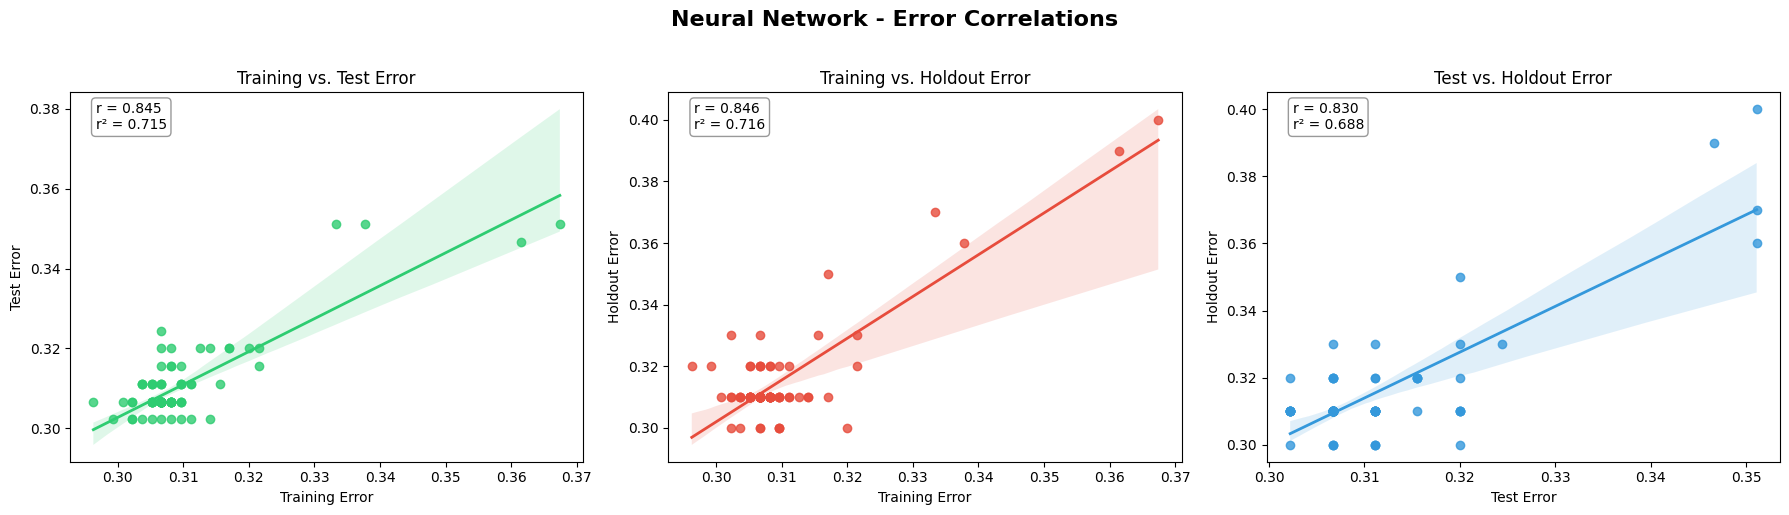


Neural Network - Correlation Summary:
  Training vs Test:    r = 0.845, r² = 0.715, p = 1.901e-28
  Training vs Holdout: r = 0.846, r² = 0.716, p = 1.568e-28
  Test vs Holdout:     r = 0.830, r² = 0.688, p = 1.472e-26

Creating correlation analysis...

CORRELATION SUMMARY TABLE
          Algorithm  Train-Test r  Train-Test r²  Train-Test p  Train-Holdout r  Train-Holdout r²  Train-Holdout p  Test-Holdout r  Test-Holdout r²  Test-Holdout p
           AdaBoost       -0.3248         0.1055        0.0010          -0.4424            0.1957           0.0000          0.2066           0.0427          0.0392
      Random Forest        0.1007         0.0101        0.3188          -0.0218            0.0005           0.8293         -0.0689           0.0047          0.4961
                SVM       -0.4084         0.1668        0.0000          -0.3252            0.1057           0.0010          0.1506           0.0227          0.1348
Logistic Regression       -0.0486         0.0024        0.6310  

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

def create_algorithm_specific_plots(results_df):
    """
    Create separate error comparison plots for each algorithm, mimicking the provided style

    Parameters:
    results_df: DataFrame with columns ['Algorithm', 'Training Error', 'Test Error', 'Holdout Error']
    """
    # Define custom colors (same as the original)
    custom_colors = ["#2ecc71",  # Green
                     "#e74c3c",  # Red
                     "#3498db",  # Blue
                     "#9b59b6"]  # Purple

    # Get unique algorithms
    algorithms = results_df['Algorithm'].unique()

    # Create plots for each algorithm
    for i, algorithm in enumerate(algorithms):
        # Filter data for current algorithm
        algo_df = results_df[results_df['Algorithm'] == algorithm].copy()

        # Set figure size for a row of 3 plots
        plt.figure(figsize=(18, 5))

        # Set the color palette
        sns.set_palette(custom_colors)

        # First plot: Training vs Test Error
        plt.subplot(1, 3, 1)
        # Calculate correlation coefficient (R) and p-value
        r_train_test, p_train_test = stats.pearsonr(algo_df['Training Error'], algo_df['Test Error'])
        r2_train_test = r_train_test**2
        # Add regression plot
        sns.regplot(data=algo_df, x='Training Error', y='Test Error',
                    scatter_kws={'color': custom_colors[0]},
                    line_kws={'color': custom_colors[0], 'linewidth': 2})
        # Add R and R² text
        plt.annotate(f'r = {r_train_test:.3f}\nr² = {r2_train_test:.3f}',
                     xy=(0.05, 0.90), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        plt.title('Training vs. Test Error')
        plt.xlabel('Training Error')
        plt.ylabel('Test Error')

        # Second plot: Training vs Holdout Error
        plt.subplot(1, 3, 2)
        # Calculate correlation coefficient (R) and p-value
        r_train_holdout, p_train_holdout = stats.pearsonr(algo_df['Training Error'], algo_df['Holdout Error'])
        r2_train_holdout = r_train_holdout**2
        # Add regression plot
        sns.regplot(data=algo_df, x='Training Error', y='Holdout Error',
                    scatter_kws={'color': custom_colors[1]},
                    line_kws={'color': custom_colors[1], 'linewidth': 2})
        # Add R and R² text
        plt.annotate(f'r = {r_train_holdout:.3f}\nr² = {r2_train_holdout:.3f}',
                     xy=(0.05, 0.90), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        plt.title('Training vs. Holdout Error')
        plt.xlabel('Training Error')
        plt.ylabel('Holdout Error')

        # Third plot: Test vs Holdout Error
        plt.subplot(1, 3, 3)
        # Calculate correlation coefficient (R) and p-value
        r_test_holdout, p_test_holdout = stats.pearsonr(algo_df['Test Error'], algo_df['Holdout Error'])
        r2_test_holdout = r_test_holdout**2
        # Add regression plot
        sns.regplot(data=algo_df, x='Test Error', y='Holdout Error',
                    scatter_kws={'color': custom_colors[2]},
                    line_kws={'color': custom_colors[2], 'linewidth': 2})
        # Add R and R² text
        plt.annotate(f'r = {r_test_holdout:.3f}\nr² = {r2_test_holdout:.3f}',
                     xy=(0.05, 0.90), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        plt.title('Test vs. Holdout Error')
        plt.xlabel('Test Error')
        plt.ylabel('Holdout Error')

        # Add main title for the algorithm
        plt.suptitle(f'{algorithm} - Error Correlations', fontsize=16, fontweight='bold', y=1.02)

        # Adjust layout to prevent overlap
        plt.tight_layout()

        # Save individual plots
        plt.savefig(f'{algorithm.replace(" ", "_")}_error_correlations.png',
                   dpi=300, bbox_inches='tight')

        # Show the plots
        plt.show()

        # Print correlation summary for this algorithm
        print(f"\n{algorithm} - Correlation Summary:")
        print(f"  Training vs Test:    r = {r_train_test:.3f}, r² = {r2_train_test:.3f}, p = {p_train_test:.3e}")
        print(f"  Training vs Holdout: r = {r_train_holdout:.3f}, r² = {r2_train_holdout:.3f}, p = {p_train_holdout:.3e}")
        print(f"  Test vs Holdout:     r = {r_test_holdout:.3f}, r² = {r2_test_holdout:.3f}, p = {p_test_holdout:.3e}")

def create_summary_correlation_table(results_df):
    """
    Create a summary table of all correlations across algorithms
    """
    algorithms = results_df['Algorithm'].unique()
    correlation_summary = []

    for algorithm in algorithms:
        algo_df = results_df[results_df['Algorithm'] == algorithm].copy()

        # Calculate correlations
        r_train_test, p_train_test = stats.pearsonr(algo_df['Training Error'], algo_df['Test Error'])
        r_train_holdout, p_train_holdout = stats.pearsonr(algo_df['Training Error'], algo_df['Holdout Error'])
        r_test_holdout, p_test_holdout = stats.pearsonr(algo_df['Test Error'], algo_df['Holdout Error'])

        correlation_summary.append({
            'Algorithm': algorithm,
            'Train-Test r': r_train_test,
            'Train-Test r²': r_train_test**2,
            'Train-Test p': p_train_test,
            'Train-Holdout r': r_train_holdout,
            'Train-Holdout r²': r_train_holdout**2,
            'Train-Holdout p': p_train_holdout,
            'Test-Holdout r': r_test_holdout,
            'Test-Holdout r²': r_test_holdout**2,
            'Test-Holdout p': p_test_holdout
        })

    correlation_df = pd.DataFrame(correlation_summary)

    print("\n" + "="*80)
    print("CORRELATION SUMMARY TABLE")
    print("="*80)
    print(correlation_df.round(4).to_string(index=False))

    return correlation_df

def analyze_correlation_patterns(results_df):
    """
    Analyze patterns in correlations across algorithms
    """
    correlation_df = create_summary_correlation_table(results_df)

    print("\n" + "="*60)
    print("CORRELATION ANALYSIS")
    print("="*60)

    # Find algorithm with highest/lowest correlations
    print(f"\nHighest Train-Test correlation: {correlation_df.loc[correlation_df['Train-Test r'].idxmax(), 'Algorithm']} "
          f"(r = {correlation_df['Train-Test r'].max():.3f})")
    print(f"Lowest Train-Test correlation:  {correlation_df.loc[correlation_df['Train-Test r'].idxmin(), 'Algorithm']} "
          f"(r = {correlation_df['Train-Test r'].min():.3f})")

    print(f"\nHighest Train-Holdout correlation: {correlation_df.loc[correlation_df['Train-Holdout r'].idxmax(), 'Algorithm']} "
          f"(r = {correlation_df['Train-Holdout r'].max():.3f})")
    print(f"Lowest Train-Holdout correlation:  {correlation_df.loc[correlation_df['Train-Holdout r'].idxmin(), 'Algorithm']} "
          f"(r = {correlation_df['Train-Holdout r'].min():.3f})")

    print(f"\nHighest Test-Holdout correlation: {correlation_df.loc[correlation_df['Test-Holdout r'].idxmax(), 'Algorithm']} "
          f"(r = {correlation_df['Test-Holdout r'].max():.3f})")
    print(f"Lowest Test-Holdout correlation:  {correlation_df.loc[correlation_df['Test-Holdout r'].idxmin(), 'Algorithm']} "
          f"(r = {correlation_df['Test-Holdout r'].min():.3f})")

    # Interpretation guide
    print(f"\n" + "="*60)
    print("INTERPRETATION GUIDE")
    print("="*60)
    print("• High Train-Test correlation suggests consistent overfitting patterns")
    print("• Low Train-Holdout correlation may indicate unstable generalization")
    print("• High Test-Holdout correlation suggests good validation set reliability")
    print("• r² values show proportion of variance explained by the relationship")

    return correlation_df

# Example usage and main execution
if __name__ == "__main__":
    # Try to load results from CSV
    try:
        results_df = result_df
        print("Loaded results from CSV file")
        print(f"Found {len(results_df)} results for {len(results_df['Algorithm'].unique())} algorithms")

        # Create algorithm-specific plots
        print("\nCreating algorithm-specific error correlation plots...")
        create_algorithm_specific_plots(results_df)

        # Create summary analysis
        print("\nCreating correlation analysis...")
        correlation_summary = analyze_correlation_patterns(results_df)

    except FileNotFoundError:
        print("No results file found. Please run the main experiment first.")
        print("Expected file: 'multi_algorithm_results.csv'")

        # Create sample data for demonstration
        print("\nCreating sample visualization with dummy data...")
        np.random.seed(42)
        algorithms = ['AdaBoost', 'Random Forest', 'SVM', 'Logistic Regression', 'Neural Network']
        sample_data = []

        for algo in algorithms:
            # Create different correlation patterns for each algorithm
            base_error = np.random.uniform(0.15, 0.25)

            for seed in range(50):  # More points for better correlation analysis
                if algo == 'AdaBoost':
                    # High correlation between train and test
                    train_err = np.random.uniform(0.1, 0.2)
                    test_err = train_err + np.random.normal(0.05, 0.02)
                    holdout_err = train_err + np.random.normal(0.06, 0.025)
                elif algo == 'Random Forest':
                    # Lower training error, moderate correlation
                    train_err = np.random.uniform(0.05, 0.15)
                    test_err = train_err + np.random.normal(0.08, 0.03)
                    holdout_err = test_err + np.random.normal(0.01, 0.02)
                elif algo == 'SVM':
                    # More consistent across all error types
                    base = np.random.uniform(0.15, 0.25)
                    train_err = base + np.random.normal(0, 0.01)
                    test_err = base + np.random.normal(0.02, 0.015)
                    holdout_err = base + np.random.normal(0.025, 0.02)
                elif algo == 'Logistic Regression':
                    # Linear relationship between errors
                    train_err = np.random.uniform(0.12, 0.22)
                    test_err = train_err * 1.1 + np.random.normal(0.01, 0.01)
                    holdout_err = train_err * 1.12 + np.random.normal(0.015, 0.015)
                else:  # Neural Network
                    # More variable, some overfitting
                    train_err = np.random.uniform(0.08, 0.18)
                    test_err = train_err + np.random.exponential(0.05)
                    holdout_err = train_err + np.random.exponential(0.06)

                # Ensure errors are positive and reasonable
                train_err = max(0.01, min(0.5, train_err))
                test_err = max(0.01, min(0.5, test_err))
                holdout_err = max(0.01, min(0.5, holdout_err))

                sample_data.append({
                    'Algorithm': algo,
                    'Seed': seed,
                    'Training Error': train_err,
                    'Test Error': test_err,
                    'Holdout Error': holdout_err
                })

        #sample_df = pd.DataFrame(sample_data)
        #print("Created sample data with realistic correlation patterns")

        # Create the visualizations with sample data
        create_algorithm_specific_plots(result_df)
        analyze_correlation_patterns(result_df)

## Interpretation of Results (Synthetic Data with Complex Linear Boundary)

#### We see almost an exact prediction of our model results for AdaBoost/SVM in the synthetic data: strong test:train anti-correlation, weaker holdout:train anti-correlation and basically no correlation in holdout:test. NN as in previous experiments had positive correlation. However, logistic regression and random forests lost any correlation.


# **Appendix**
## Future Directions to Consider
#### Multi-class classification


*   Running AdaBoost on a multiclass classification problem using SAMME.R, a real variant of Stagewise Additive Modeling using a Multi-class Exponential loss function that uses class probabilities from the base estimator. This procedure allows AdaBoost to run on non-binary classification tasks.


*  We are computing empirical classification error, i.e., 0-1 loss. So there is no weighting done on the mislabeling.

* We suspect that this diffuses anti-correlation, but must examine these effects further.



## Anaylsis of UCI Wine Quality Data Set

#### Data of Portugal wines predicting their quality score. Processed slightly differently as this is now a multiclass classification problem. We are no longer using decision stumps, but trees of max length 3. We only consider red wines.

## Relevant Features

#### - Multiclass: (8) Possible target values
#### - Medium Data set ~1.5k instances
#### - 12 Features

In [ ]:
# 1. Load Wine Quality dataset (multiclass: target = wine quality score)
def load_wine_data():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
    response = requests.get(url)
    data = pd.read_csv(StringIO(response.text), sep=';')

    return data

# 2. Preprocess the data
def preprocess_wine_data(data):
    X = data.drop('quality', axis=1)
    y = data['quality']  # Multiclass target (scores like 3, 4, ..., 8)

    numeric_features = X.columns.tolist()
    numeric_transformer = StandardScaler()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features)
        ])

    return X, y, preprocessor

# 3. Run the AdaBoost experiment
def run_adaboost_experiment(X, y, preprocessor, n_runs=100):
    base_learner = DecisionTreeClassifier(max_depth=3)
    results = []

    for seed in range(n_runs):
        X_train_val, X_holdout, y_train_val, y_holdout = train_test_split(
            X, y, test_size=0.1, random_state=seed, stratify=y)

        X_train, X_test, y_train, y_test = train_test_split(
            X_train_val, y_train_val, test_size=0.25, random_state=seed, stratify=y_train_val)

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', AdaBoostClassifier(
                estimator=base_learner,
                n_estimators=50,
                random_state=seed))
        ])

        pipeline.fit(X_train, y_train)

        train_error = 1 - accuracy_score(y_train, pipeline.predict(X_train))
        test_error = 1 - accuracy_score(y_test, pipeline.predict(X_test))
        holdout_error = 1 - accuracy_score(y_holdout, pipeline.predict(X_holdout))

        results.append({
            'seed': seed,
            'Training Error': train_error,
            'Test Error': test_error,
            'Holdout Error': holdout_error
        })

    return pd.DataFrame(results)

# Run everything
if __name__ == "__main__":
    wine_data = load_wine_data()
    print(f"Dataset shape: {wine_data.shape}")

    X, y, preprocessor = preprocess_wine_data(wine_data)

    wine_results = run_adaboost_experiment(X, y, preprocessor, n_runs=100)


Dataset shape: (1599, 12)


## Visulation of Results (UCI Wine Quality)

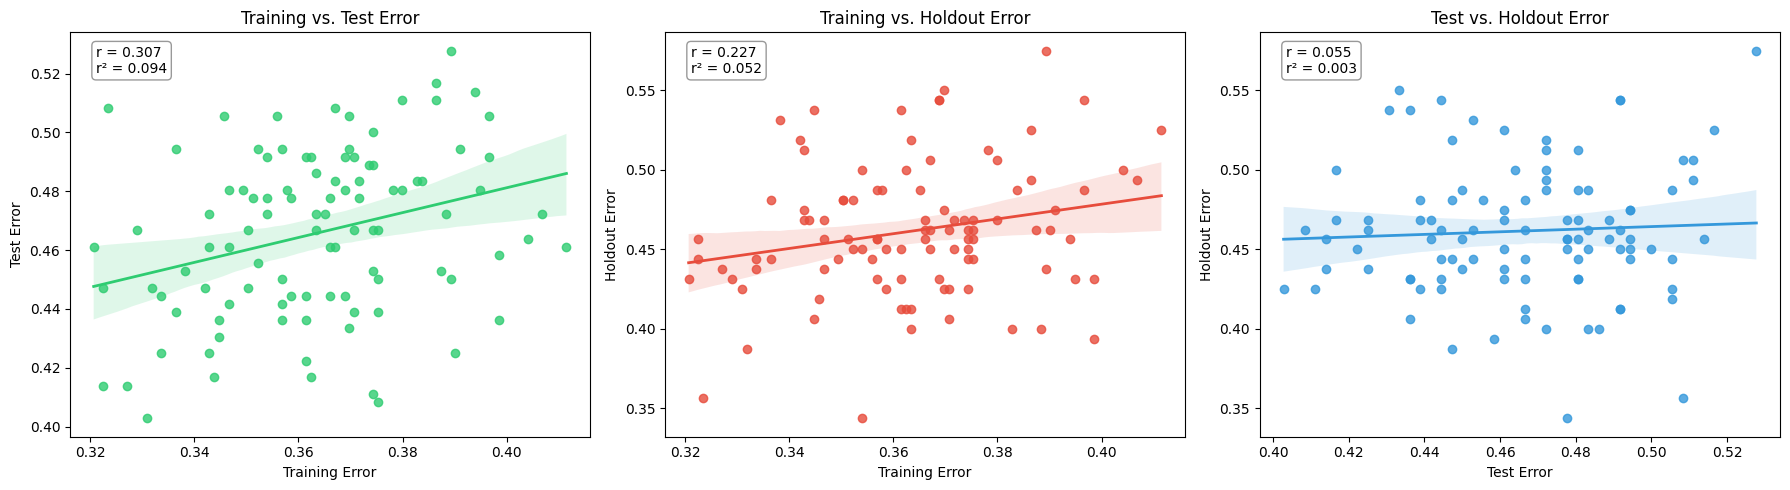

In [ ]:
# Step 8: Set figure size for a row of 3 plots
plt.figure(figsize=(18, 5))

# Define custom colors
custom_colors = ["#2ecc71",  # Green
                 "#e74c3c",  # Red
                 "#3498db",  # Blue
                 "#9b59b6"]  # Purple
sns.set_palette(custom_colors)

# First plot: Training vs Test Error
plt.subplot(1, 3, 1)
# Calculate correlation coefficient (R) and p-value
r_train_test, p_train_test = stats.pearsonr(wine_results['Training Error'], wine_results['Test Error'])
r2_train_test = r_train_test**2
# Add regression plot
sns.regplot(data=wine_results, x='Training Error', y='Test Error',
            scatter_kws={'color': custom_colors[0]},
            line_kws={'color': custom_colors[0], 'linewidth': 2})
# Add R and R² text
plt.annotate(f'r = {r_train_test:.3f}\nr² = {r2_train_test:.3f}',
             xy=(0.05, 0.90), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.title('Training vs. Test Error')
plt.xlabel('Training Error')
plt.ylabel('Test Error')

# Second plot: Training vs Holdout Error
plt.subplot(1, 3, 2)
# Calculate correlation coefficient (R) and p-value
r_train_holdout, p_train_holdout = stats.pearsonr(wine_results['Training Error'], wine_results['Holdout Error'])
r2_train_holdout = r_train_holdout**2
# Add regression plot
sns.regplot(data=wine_results, x='Training Error', y='Holdout Error',
            scatter_kws={'color': custom_colors[1]},
            line_kws={'color': custom_colors[1], 'linewidth': 2})
# Add R and R² text
plt.annotate(f'r = {r_train_holdout:.3f}\nr² = {r2_train_holdout:.3f}',
             xy=(0.05, 0.90), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.title('Training vs. Holdout Error')
plt.xlabel('Training Error')
plt.ylabel('Holdout Error')

# Third plot: Test vs Holdout Error
plt.subplot(1, 3, 3)
# Calculate correlation coefficient (R) and p-value
r_test_holdout, p_test_holdout = stats.pearsonr(wine_results['Test Error'], wine_results['Holdout Error'])
r2_test_holdout = r_test_holdout**2
# Add regression plot
sns.regplot(data=wine_results, x='Test Error', y='Holdout Error',
            scatter_kws={'color': custom_colors[2]},
            line_kws={'color': custom_colors[2], 'linewidth': 2})
# Add R and R² text
plt.annotate(f'r = {r_test_holdout:.3f}\nr² = {r2_test_holdout:.3f}',
             xy=(0.05, 0.90), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.title('Test vs. Holdout Error')
plt.xlabel('Test Error')
plt.ylabel('Holdout Error')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


## Interpretation of Results (UCI Wine Quality)

#### We have lost the anti-correlation and see a very vague correlation between test and train. This is expected, in binary classification, each example is either right or wrong based on one threshold. In multiclass, there are multiple possible ways to be wrong; diffusing the impact of overfitting. Thus, the variance of error rates per fold can be lower creating a less pronounced covariance structure.